# Syn vs Nonsyn and Non-nonsense vs Nonsense mutation rates

## Based on positions, instead of codons!

This makes it easier to use these for FDR estimation.

In [1]:
%run "Header.ipynb"
%run "GeneUtils.ipynb"

In [2]:
import time
import json
import pickle
import skbio
import pileup
from collections import defaultdict
from parse_sco import parse_sco

In [3]:
seq2pos2pileup = pileup.load()

## Percentages (values of $p$) for naive mutation calling

### Values we use for plotting
Currently the same as in the codon mutation notebook. I guess these should be a shared variable, ideally? But that might be too much work for its own good.

In [4]:
percentages = [2, 1, 0.5, 0.25, 0.15]

### Full values, used for plotting a FDR curve elsewhere

Copied from the target/decoy notebook. may be nice to generalize to shared code too i guess

In [5]:
# Percentages go from 4.99%, 4.98%, ..., 0.16%, 0.15%
full_percentages = [p / 100 for p in range(15, 500, 1)][::-1]
print(f"First two percentages: {full_percentages[:2]}")
print(f"Last two percentages: {full_percentages[-2:]}")
print(f"Number of percentages: {len(full_percentages):,}")

First two percentages: [4.99, 4.98]
Last two percentages: [0.16, 0.15]
Number of percentages: 485


In [10]:
# Sanity check -- we can just compute this data for all of the stuff in full_percentages
# and then for the stuff we wanna plot in this notebook just focus on the values in percentages
for p in percentages:
    assert p in full_percentages, f"{p}% not in full_percentages"

## Compute possible (non)synonymous and (non)nonsense mutations, in general

Not specific to a given MAG -- just in the context of all possible codons, using the standard genetic code.

In [14]:
codons = []
dna = "ACGT"
for x in dna:
    for y in dna:
        for z in dna:
            codons.append(x+y+z)
            
# Maps the 64 codons --> [1, 2, 3] --> an integer 0, 1, 2, or 3, indicating how many of the 3 mutations
# from this CP in this codon into another nucleotide are synonymous (si) or nonsynonymous (ni)
codon2cp2si = defaultdict(dict)
codon2cp2ni = defaultdict(dict)

# Like above, but for non-nonsense (nnsi) or nonsense (nsi) mutations and only for the 61 sense codons
codon2cp2nnsi = defaultdict(dict)
codon2cp2nsi = defaultdict(dict)

stop_codons = []

total_si = 0
total_ni = 0
total_nnsi = 0
total_nsi = 0

for c in codons:
    
    is_not_stop = not (str(skbio.DNA(c).translate()) == "*")
    if not is_not_stop:
        stop_codons.append(c)
        
    for pos in [0, 1, 2]:
        si = 0
        ni = 0
        nnsi = 0
        nsi = 0
        
        si_cp2 = 0
        ni_cp2 = 0
        nnsi_cp2 = 0
        nsi_cp2 = 0
        
        for alt_nt in set(dna) - set(c[pos]):
            alt_codon = c[:pos] + alt_nt + c[pos + 1:]
            aa1 = str(skbio.DNA(c).translate())
            aa2 = str(skbio.DNA(alt_codon).translate())
            if aa1 == aa2:
                si += 1
                if is_not_stop:
                    nnsi += 1
            else:
                ni += 1
                if pos == 1:
                    ni_cp2 += 1
                if is_not_stop:
                    if aa2 == "*":
                        nsi += 1
                    else:
                        nnsi += 1
                    
        assert si + ni == 3
        # (the pos + 1 is done because the CPs above are 0-indexed [i.e. 0, 1, 2], while below we'll deal with
        # 1-indexed CPs [i.e. 1, 2, 3])
        codon2cp2si[c][pos + 1] = si
        codon2cp2ni[c][pos + 1] = ni
        
        total_si += si
        total_ni += ni
        
        if is_not_stop:
            assert nsi + nnsi == 3
            codon2cp2nnsi[c][pos + 1] = nnsi
            codon2cp2nsi[c][pos + 1] = nsi
            
            total_nnsi += nnsi
            total_nsi += nsi
            
assert len(codon2cp2si) == len(codon2cp2ni) == 64
assert len(codon2cp2nnsi) == len(codon2cp2nsi) == 61
assert len(stop_codons) == 3

In [15]:
print(f"Total Si: {total_si}; Total Ni: {total_ni}")
print(f"Total NNSi: {total_nnsi}; Total NSi: {total_nsi}")

Total Si: 138; Total Ni: 438
Total NNSi: 526; Total NSi: 23


## Use these numbers to compute $\sum_i S_i$ (and $N_i$, $NNS_i$, $NS_i$) for all MAGs; and call mutations of these types!

Main hurdle of this analysis. Could be optimized more (replace naive mutation calling once for every value of p for  a position with just extracting the alt nt freq for this position and compare against p), but good enough for now.

In [19]:
# seq --> list of 1-indexed positions where a mutation here can be nonsyn or nonsense
seq2poss_nonsyn_positions = {}
seq2poss_nonsense_positions = {}

# Total poss numbers of single-nucleotide (non)synonymous and (non)nonsense mutations throughout the genomes
seq2poss_si = defaultdict(int)
seq2poss_ni = defaultdict(int)
seq2poss_nnsi = defaultdict(int)
seq2poss_nsi = defaultdict(int)

# Above, but filtered to just CP2
seq2poss_cp2_si = defaultdict(int)
seq2poss_cp2_ni = defaultdict(int)
seq2poss_cp2_nnsi = defaultdict(int)
seq2poss_cp2_nsi = defaultdict(int)

# Defined the same as in the earlier codon-based S/N notebook.
p2seq2obs_si = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_ni = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nnsi = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nsi = {p: defaultdict(int) for p in full_percentages}

# Subsets of the above -- only consider mutations at CP2 positions
p2seq2obs_cp2_si = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_cp2_ni = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_cp2_nnsi = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_cp2_nsi = {p: defaultdict(int) for p in full_percentages}

# More information about nonsense mutations -- just to prove to myself that this is working
# correctly, record all positions that are "nonsense" mutations
p2seq2obs_pos_nsi = {p: defaultdict(list) for p in full_percentages}
p2seq2obs_pos_cp2_nsi = {p: defaultdict(list) for p in full_percentages}

# For debugging... I don't recommend using this otherwise due to how much gets printed out!
verbose = False

t0 = time.time()
for seq in SEQS:
    print(f"On {seq}. Runtime: {time.time() - t0:,.2f} sec.")
    df = parse_sco(f"../seqs/genes/{seq}.sco")
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    # Figure out quickly which positions are in multiple genes, so we can ignore them
    pos_to_genes = get_parent_gene_info_of_many_positions(df)
    
    poss_nonsyn_pos = []
    poss_nonsense_pos = []
    
    for gene in df.itertuples():
        t0g = time.time()
#         stats = (
#             f"So far {len(poss_nonsyn_pos):,} poss nonsyn and {len(poss_nonsense_pos):,} "
#             "poss nonsense positions."
#         )
        stats = (
            f"So far @ p = 0.5%, Si/Ni = {p2seq2obs_si[0.5][seq]:,}/"
            f"{p2seq2obs_ni[0.5][seq]:,}, NNSi/NSi = {p2seq2obs_nnsi[0.5][seq]:,}/{p2seq2obs_nsi[0.5][seq]:,}.\n\t"
            f"For CP2 @ p = 0.5%, Si/Ni = {p2seq2obs_cp2_si[0.5][seq]:,}/"
            f"{p2seq2obs_cp2_ni[0.5][seq]:,}, NNSi/NSi = "
            f"{p2seq2obs_cp2_nnsi[0.5][seq]:,}/{p2seq2obs_cp2_nsi[0.5][seq]:,}."
            
        )
        print(
            f"{seq2name[seq]}: On gene {gene.Index:,} / {len(df.index):,}. "
            f"{stats} Runtime: {time.time() - t0:,.2f} sec."
        )
        # The order of positions we go through is dependent on gene orientation:
        # left --> right if this is a "+" strand gene,
        # right --> left if this is a "-" strand gene.
        pos_interval = get_pos_interval_from_gene(gene)
        
        # We'll update these values as we walk through the gene.
        # curr_codon_cp1_pos indicates CP1 (the left end for + genes, the right end for - genes)
        # of the current gene. It's 1-indexed, along with the gene coordinates.
        curr_codon_cp1_pos = pos_interval[0]
        # Always either 1, 2, or 3. Note that pos_interval is ordered depending on the gene orientation,
        # so long story short we can reliably just count CP as 1, 2, 3, 1, 2, 3, ... without worrying much.
        cp = 1
        
        for pos in pos_interval:
            if verbose: print(f"On position {pos:,} (CP {cp}) ")
            if cp == 1:
                # It's easier to sync this at the top rather than bottom of the loop because the positions
                # in pos_interval could be increasing or decreasing depending on the gene's strand
                curr_codon_cp1_pos = pos
            
            # We don't attempt mutation calling at multi-gene positions, or at
            # unreasonable (ref != consensus) positions.
            
            # ... And now we actually naively try to call a mutation at this position (trying lots of
            # values of p at once so we can create an FDR curve, barplots, etc).
            pos_pileup = seq2pos2pileup[seq][pos]
            
            if len(pos_to_genes[pos]) == 1 and pileup.is_reasonable(pos_pileup):
                
                if verbose: print("\tReasonable and in just 1 gene ", end="")
                    
                if gene.Strand == "+":
                    # The skbio sequence is 0-indexed, so we gotta subtract by 1
                    parent_codon_fasta = fasta[curr_codon_cp1_pos - 1: curr_codon_cp1_pos + 2]
                    if verbose:
                        print(f"(+); parent codon is {parent_codon_fasta}")
                    
                elif gene.Strand == "-":
                    parent_codon_fwd_fasta = fasta[curr_codon_cp1_pos - 3: curr_codon_cp1_pos]
                    parent_codon_fwd_str = str(parent_codon_fwd_fasta)
                    parent_codon_fasta = parent_codon_fwd_fasta.reverse_complement()
                    if verbose:
                        print(
                            f"(-); parent codon (not RC'd) is {parent_codon_fwd_fasta}; "
                            f"RC'd, it's {parent_codon_fasta} ({parent_codon_fasta.translate()})"
                        )
                
                else:
                    raise ValueError(f"Invalid strand: {gene.Strand}")
                
                parent_codon_str = str(parent_codon_fasta)
                
                # Update possible Si|Ni and NNSi|NSi values based on this position and its parent codon.
                seq2poss_si[seq] += codon2cp2si[parent_codon_str][cp]
                seq2poss_ni[seq] += codon2cp2ni[parent_codon_str][cp]
                if cp == 2:
                    seq2poss_cp2_si[seq] += codon2cp2si[parent_codon_str][cp]
                    seq2poss_cp2_ni[seq] += codon2cp2ni[parent_codon_str][cp]
                    
                if codon2cp2ni[parent_codon_str][cp] > 0:
                    poss_nonsyn_pos.append(pos)
                    
                if verbose:
                    print(
                        f"\tSi = {codon2cp2si[parent_codon_str][cp]}, "
                        f"Ni = {codon2cp2ni[parent_codon_str][cp]}"
                    )
                    
                in_sense_codon = (parent_codon_str not in stop_codons)
                if in_sense_codon:
                    seq2poss_nnsi[seq] += codon2cp2nnsi[parent_codon_str][cp]
                    seq2poss_nsi[seq] += codon2cp2nsi[parent_codon_str][cp]
                    if cp == 2:
                        seq2poss_cp2_nnsi[seq] += codon2cp2nnsi[parent_codon_str][cp]
                        seq2poss_cp2_nsi[seq] += codon2cp2nsi[parent_codon_str][cp]
                    
                    if codon2cp2nsi[parent_codon_str][cp] > 0:
                        poss_nonsense_pos.append(pos)
                        
                    if verbose:
                        print(
                            f"\tPosition is in a sense codon, and "
                            f"NNSi = {codon2cp2nnsi[parent_codon_str][cp]}, "
                            f"NSi = {codon2cp2nsi[parent_codon_str][cp]}"
                        )
                
                # Since we currently define mutations as a binary thing (either a position is mutated
                # or it isn't), we can precompute the step of figuring out the mutated codon resulting from
                # a position being called a mutation -- and we can thus figure out in advance if this position
                # will be a (non)synonymous or (non)nonsense mutation, before actually calling it a mutation
                # (...should save some time).

                if pileup.any_mismatches(pos_pileup):
                    alt_nt = pileup.get_alt_nt_if_reasonable(pos_pileup)

                    if verbose: print(f"\tPosition has mismatches; max freq alt nt is {alt_nt}")

                    # if alt_nt is None, it means this position was unreasonable -- but we've already
                    # verified above that this position is reasonable!
                    assert alt_nt is not None

                    # Construct a "mutated" version of this position's parent codon, with just this
                    # alternate nucleotide changed. This doesn't take into account the possibility
                    # of other positions within this codon being mutated, which is a notable limitation
                    # of this approach.
                    if gene.Strand == "+":
                        mutated_parent_codon = parent_codon_fasta.replace([cp - 1], alt_nt)
                    else:
                        # Do two things: 1) convert from a reverse-direction CP to a fwd-direction CP,
                        # and 2) switch to using 0-indexing so we can work with skbio.DNA objects.
                        if cp == 1: idx_to_replace = 2
                        elif cp == 2: idx_to_replace = 1
                        else: idx_to_replace = 0

                        # Apply the mutation, *then* reverse-complement the codon
                        mutated_parent_codon_fwd = parent_codon_fwd_fasta.replace([idx_to_replace], alt_nt)
                        mutated_parent_codon = mutated_parent_codon_fwd.reverse_complement()
                
                    aa1 = str(parent_codon_fasta.translate())
                    aa2 = str(mutated_parent_codon.translate())
                    
                    is_syn = (aa1 == aa2)
                    aa2_is_stop = (aa2 == "*")
                    
                    if verbose:
                        print(f"\tAlt codon is {mutated_parent_codon} ({aa2}); is syn? {is_syn}")
                    
                    # We don't go through this step if pileup.any_mismatches() is False! Because... in that
                    # case, this position can never be a p-mutation. So we can save a lot of time.
                    for p in full_percentages:

                        if pileup.naively_call_mutation(pos_pileup, p, only_call_if_rare=True):
                            if verbose:
                                print(f"\tIs (rare) mut at p = {p}!")
                            if is_syn:
                                p2seq2obs_si[p][seq] += 1
                                if cp == 2:
                                    p2seq2obs_cp2_si[p][seq] += 1
                                    
                            else:
                                p2seq2obs_ni[p][seq] += 1
                                if cp == 2:
                                    p2seq2obs_cp2_ni[p][seq] += 1

                            if in_sense_codon:
                                if aa2_is_stop:
                                    p2seq2obs_nsi[p][seq] += 1
                                    p2seq2obs_pos_nsi[p][seq].append(pos)
                                    if cp == 2:
                                        p2seq2obs_cp2_nsi[p][seq] += 1
                                        p2seq2obs_pos_cp2_nsi[p][seq].append(pos)
                                        
                                else:
                                    p2seq2obs_nnsi[p][seq] += 1
                                    if cp == 2:
                                        p2seq2obs_cp2_nnsi[p][seq] += 1
                        
            cp = next_cp(cp)
    
    seq2poss_nonsyn_positions[seq] = poss_nonsyn_pos
    seq2poss_nonsense_positions[seq] = poss_nonsense_pos
    
print(f"Done. Runtime: {time.time() - t0:,.2f} sec.")

On edge_6104. Runtime: 0.00 sec.
CAMP: On gene 1 / 1,297. So far @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 0.48 sec.
CAMP: On gene 2 / 1,297. So far @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 0.79 sec.
CAMP: On gene 3 / 1,297. So far @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 1.04 sec.
CAMP: On gene 4 / 1,297. So far @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 1.36 sec.
CAMP: On gene 5 / 1,297. So far @ p = 0.5%, Si/Ni = 0/1, NNSi/NSi = 1/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 2.24 sec.
CAMP: On gene 6 / 1,297. So far @ p = 0.5%, Si/Ni = 0/1, NNSi/NSi = 1/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 2.42 sec.
CAMP: On gene 7 / 1,297. So far @ p = 0.5%, Si/Ni = 0/1, NNSi/NSi = 1/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi

CAMP: On gene 58 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 31.72 sec.
CAMP: On gene 59 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 32.17 sec.
CAMP: On gene 60 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 32.32 sec.
CAMP: On gene 61 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 32.54 sec.
CAMP: On gene 62 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 32.74 sec.
CAMP: On gene 63 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 32.83 sec.
CAMP: On gene 64 / 1,297. So far @ p = 0.5%, Si/Ni = 0/4, NNSi/NSi = 4/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/0, NNSi/NSi = 0/0. Runtime: 33.

CAMP: On gene 116 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 58.92 sec.
CAMP: On gene 117 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 59.24 sec.
CAMP: On gene 118 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 59.65 sec.
CAMP: On gene 119 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 59.99 sec.
CAMP: On gene 120 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 60.48 sec.
CAMP: On gene 121 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runtime: 60.84 sec.
CAMP: On gene 122 / 1,297. So far @ p = 0.5%, Si/Ni = 1/7, NNSi/NSi = 7/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/2, NNSi/NSi = 1/0. Runti

CAMP: On gene 173 / 1,297. So far @ p = 0.5%, Si/Ni = 2/14, NNSi/NSi = 13/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/6, NNSi/NSi = 4/0. Runtime: 85.25 sec.
CAMP: On gene 174 / 1,297. So far @ p = 0.5%, Si/Ni = 2/14, NNSi/NSi = 13/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/6, NNSi/NSi = 4/0. Runtime: 85.71 sec.
CAMP: On gene 175 / 1,297. So far @ p = 0.5%, Si/Ni = 2/14, NNSi/NSi = 13/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/6, NNSi/NSi = 4/0. Runtime: 86.17 sec.
CAMP: On gene 176 / 1,297. So far @ p = 0.5%, Si/Ni = 2/14, NNSi/NSi = 13/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/6, NNSi/NSi = 4/0. Runtime: 86.57 sec.
CAMP: On gene 177 / 1,297. So far @ p = 0.5%, Si/Ni = 2/14, NNSi/NSi = 13/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/6, NNSi/NSi = 4/0. Runtime: 86.90 sec.
CAMP: On gene 178 / 1,297. So far @ p = 0.5%, Si/Ni = 2/16, NNSi/NSi = 15/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/7, NNSi/NSi = 5/0. Runtime: 88.18 sec.
CAMP: On gene 179 / 1,297. So far @ p = 0.5%, Si/Ni = 2/16, NNSi/NSi = 15/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/7, NNSi/NS

CAMP: On gene 229 / 1,297. So far @ p = 0.5%, Si/Ni = 2/19, NNSi/NSi = 18/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/7, NNSi/NSi = 5/0. Runtime: 117.45 sec.
CAMP: On gene 230 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, NNSi/NSi = 7/0. Runtime: 117.96 sec.
CAMP: On gene 231 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, NNSi/NSi = 7/0. Runtime: 118.63 sec.
CAMP: On gene 232 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, NNSi/NSi = 7/0. Runtime: 119.75 sec.
CAMP: On gene 233 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, NNSi/NSi = 7/0. Runtime: 120.15 sec.
CAMP: On gene 234 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, NNSi/NSi = 7/0. Runtime: 121.01 sec.
CAMP: On gene 235 / 1,297. So far @ p = 0.5%, Si/Ni = 2/24, NNSi/NSi = 22/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/9, N

CAMP: On gene 285 / 1,297. So far @ p = 0.5%, Si/Ni = 4/31, NNSi/NSi = 30/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 151.38 sec.
CAMP: On gene 286 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 152.16 sec.
CAMP: On gene 287 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 152.71 sec.
CAMP: On gene 288 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 152.98 sec.
CAMP: On gene 289 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 153.37 sec.
CAMP: On gene 290 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/10, NNSi/NSi = 8/0. Runtime: 153.88 sec.
CAMP: On gene 291 / 1,297. So far @ p = 0.5%, Si/Ni = 5/31, NNSi/NSi = 31/2.
	For CP2 @ p = 0.5%, Si/Ni = 

CAMP: On gene 340 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 181.38 sec.
CAMP: On gene 341 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 181.90 sec.
CAMP: On gene 342 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 182.65 sec.
CAMP: On gene 343 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 183.52 sec.
CAMP: On gene 344 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 183.78 sec.
CAMP: On gene 345 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 11/2. Runtime: 184.73 sec.
CAMP: On gene 346 / 1,297. So far @ p = 0.5%, Si/Ni = 5/39, NNSi/NSi = 37/4.
	For CP2 @ p = 0.5%, Si

CAMP: On gene 395 / 1,297. So far @ p = 0.5%, Si/Ni = 9/42, NNSi/NSi = 44/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/16, NNSi/NSi = 12/2. Runtime: 212.09 sec.
CAMP: On gene 396 / 1,297. So far @ p = 0.5%, Si/Ni = 9/42, NNSi/NSi = 44/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/16, NNSi/NSi = 12/2. Runtime: 212.55 sec.
CAMP: On gene 397 / 1,297. So far @ p = 0.5%, Si/Ni = 9/42, NNSi/NSi = 44/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/16, NNSi/NSi = 12/2. Runtime: 212.71 sec.
CAMP: On gene 398 / 1,297. So far @ p = 0.5%, Si/Ni = 9/42, NNSi/NSi = 44/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/16, NNSi/NSi = 12/2. Runtime: 212.96 sec.
CAMP: On gene 399 / 1,297. So far @ p = 0.5%, Si/Ni = 9/42, NNSi/NSi = 44/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/16, NNSi/NSi = 12/2. Runtime: 213.22 sec.
CAMP: On gene 400 / 1,297. So far @ p = 0.5%, Si/Ni = 9/44, NNSi/NSi = 46/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/17, NNSi/NSi = 13/2. Runtime: 213.68 sec.
CAMP: On gene 401 / 1,297. So far @ p = 0.5%, Si/Ni = 9/44, NNSi/NSi = 46/4.
	For CP2 @ p = 0.5%, Si

CAMP: On gene 450 / 1,297. So far @ p = 0.5%, Si/Ni = 10/48, NNSi/NSi = 51/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/19, NNSi/NSi = 15/2. Runtime: 237.37 sec.
CAMP: On gene 451 / 1,297. So far @ p = 0.5%, Si/Ni = 10/48, NNSi/NSi = 51/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/19, NNSi/NSi = 15/2. Runtime: 238.17 sec.
CAMP: On gene 452 / 1,297. So far @ p = 0.5%, Si/Ni = 10/49, NNSi/NSi = 52/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/20, NNSi/NSi = 16/2. Runtime: 238.64 sec.
CAMP: On gene 453 / 1,297. So far @ p = 0.5%, Si/Ni = 10/49, NNSi/NSi = 52/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/20, NNSi/NSi = 16/2. Runtime: 238.81 sec.
CAMP: On gene 454 / 1,297. So far @ p = 0.5%, Si/Ni = 10/49, NNSi/NSi = 52/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/20, NNSi/NSi = 16/2. Runtime: 239.62 sec.
CAMP: On gene 455 / 1,297. So far @ p = 0.5%, Si/Ni = 10/49, NNSi/NSi = 52/4.
	For CP2 @ p = 0.5%, Si/Ni = 0/20, NNSi/NSi = 16/2. Runtime: 240.34 sec.
CAMP: On gene 456 / 1,297. So far @ p = 0.5%, Si/Ni = 10/49, NNSi/NSi = 52/4.
	For CP2 @ p = 0

CAMP: On gene 505 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 264.22 sec.
CAMP: On gene 506 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 264.79 sec.
CAMP: On gene 507 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 264.95 sec.
CAMP: On gene 508 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 265.08 sec.
CAMP: On gene 509 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 265.27 sec.
CAMP: On gene 510 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/24, NNSi/NSi = 19/3. Runtime: 265.64 sec.
CAMP: On gene 511 / 1,297. So far @ p = 0.5%, Si/Ni = 11/56, NNSi/NSi = 59/5.
	For CP2 @ p = 0

CAMP: On gene 561 / 1,297. So far @ p = 0.5%, Si/Ni = 11/58, NNSi/NSi = 61/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 291.49 sec.
CAMP: On gene 562 / 1,297. So far @ p = 0.5%, Si/Ni = 11/58, NNSi/NSi = 61/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 291.76 sec.
CAMP: On gene 563 / 1,297. So far @ p = 0.5%, Si/Ni = 11/58, NNSi/NSi = 61/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 292.24 sec.
CAMP: On gene 564 / 1,297. So far @ p = 0.5%, Si/Ni = 11/60, NNSi/NSi = 63/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 292.95 sec.
CAMP: On gene 565 / 1,297. So far @ p = 0.5%, Si/Ni = 11/60, NNSi/NSi = 63/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 293.33 sec.
CAMP: On gene 566 / 1,297. So far @ p = 0.5%, Si/Ni = 11/60, NNSi/NSi = 63/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 20/3. Runtime: 293.63 sec.
CAMP: On gene 567 / 1,297. So far @ p = 0.5%, Si/Ni = 11/60, NNSi/NSi = 63/5.
	For CP2 @ p = 0

CAMP: On gene 616 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 319.90 sec.
CAMP: On gene 617 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 320.71 sec.
CAMP: On gene 618 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 321.04 sec.
CAMP: On gene 619 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 321.74 sec.
CAMP: On gene 620 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 322.05 sec.
CAMP: On gene 621 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/26, NNSi/NSi = 21/3. Runtime: 322.68 sec.
CAMP: On gene 622 / 1,297. So far @ p = 0.5%, Si/Ni = 11/62, NNSi/NSi = 65/5.
	For CP2 @ p = 0

CAMP: On gene 671 / 1,297. So far @ p = 0.5%, Si/Ni = 11/65, NNSi/NSi = 68/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 344.94 sec.
CAMP: On gene 672 / 1,297. So far @ p = 0.5%, Si/Ni = 11/66, NNSi/NSi = 69/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 345.91 sec.
CAMP: On gene 673 / 1,297. So far @ p = 0.5%, Si/Ni = 11/66, NNSi/NSi = 69/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 346.25 sec.
CAMP: On gene 674 / 1,297. So far @ p = 0.5%, Si/Ni = 11/66, NNSi/NSi = 69/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 346.82 sec.
CAMP: On gene 675 / 1,297. So far @ p = 0.5%, Si/Ni = 11/68, NNSi/NSi = 70/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 347.07 sec.
CAMP: On gene 676 / 1,297. So far @ p = 0.5%, Si/Ni = 11/68, NNSi/NSi = 70/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 347.42 sec.
CAMP: On gene 677 / 1,297. So far @ p = 0.5%, Si/Ni = 11/68, NNSi/NSi = 70/6.
	For CP2 @ p = 0

CAMP: On gene 726 / 1,297. So far @ p = 0.5%, Si/Ni = 11/70, NNSi/NSi = 72/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 370.13 sec.
CAMP: On gene 727 / 1,297. So far @ p = 0.5%, Si/Ni = 11/70, NNSi/NSi = 72/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 370.42 sec.
CAMP: On gene 728 / 1,297. So far @ p = 0.5%, Si/Ni = 11/70, NNSi/NSi = 72/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 371.07 sec.
CAMP: On gene 729 / 1,297. So far @ p = 0.5%, Si/Ni = 11/71, NNSi/NSi = 73/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/27, NNSi/NSi = 22/3. Runtime: 371.45 sec.
CAMP: On gene 730 / 1,297. So far @ p = 0.5%, Si/Ni = 11/73, NNSi/NSi = 75/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 372.70 sec.
CAMP: On gene 731 / 1,297. So far @ p = 0.5%, Si/Ni = 11/73, NNSi/NSi = 75/6.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 372.96 sec.
CAMP: On gene 732 / 1,297. So far @ p = 0.5%, Si/Ni = 11/73, NNSi/NSi = 75/6.
	For CP2 @ p = 0

CAMP: On gene 781 / 1,297. So far @ p = 0.5%, Si/Ni = 11/79, NNSi/NSi = 80/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 398.00 sec.
CAMP: On gene 782 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 398.23 sec.
CAMP: On gene 783 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 398.40 sec.
CAMP: On gene 784 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 398.52 sec.
CAMP: On gene 785 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 399.28 sec.
CAMP: On gene 786 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/28, NNSi/NSi = 23/3. Runtime: 400.00 sec.
CAMP: On gene 787 / 1,297. So far @ p = 0.5%, Si/Ni = 11/80, NNSi/NSi = 81/7.
	For CP2 @ p = 0

CAMP: On gene 836 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 425.81 sec.
CAMP: On gene 837 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 425.96 sec.
CAMP: On gene 838 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 426.30 sec.
CAMP: On gene 839 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 426.72 sec.
CAMP: On gene 840 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 427.31 sec.
CAMP: On gene 841 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 427.87 sec.
CAMP: On gene 842 / 1,297. So far @ p = 0.5%, Si/Ni = 12/85, NNSi/NSi = 87/7.
	For CP2 @ p = 0

CAMP: On gene 891 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 454.20 sec.
CAMP: On gene 892 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 454.73 sec.
CAMP: On gene 893 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 455.83 sec.
CAMP: On gene 894 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 456.09 sec.
CAMP: On gene 895 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 456.22 sec.
CAMP: On gene 896 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0.5%, Si/Ni = 0/31, NNSi/NSi = 26/3. Runtime: 456.39 sec.
CAMP: On gene 897 / 1,297. So far @ p = 0.5%, Si/Ni = 16/88, NNSi/NSi = 93/8.
	For CP2 @ p = 0

CAMP: On gene 946 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 486.96 sec.
CAMP: On gene 947 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 489.51 sec.
CAMP: On gene 948 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 491.97 sec.
CAMP: On gene 949 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 492.20 sec.
CAMP: On gene 950 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 492.49 sec.
CAMP: On gene 951 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	For CP2 @ p = 0.5%, Si/Ni = 0/35, NNSi/NSi = 29/4. Runtime: 492.91 sec.
CAMP: On gene 952 / 1,297. So far @ p = 0.5%, Si/Ni = 19/95, NNSi/NSi = 101/10.
	F

CAMP: On gene 1,001 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 511.57 sec.
CAMP: On gene 1,002 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 511.68 sec.
CAMP: On gene 1,003 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 511.89 sec.
CAMP: On gene 1,004 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 511.99 sec.
CAMP: On gene 1,005 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 512.22 sec.
CAMP: On gene 1,006 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NSi = 103/11.
	For CP2 @ p = 0.5%, Si/Ni = 0/38, NNSi/NSi = 31/5. Runtime: 512.28 sec.
CAMP: On gene 1,007 / 1,297. So far @ p = 0.5%, Si/Ni = 19/98, NNSi/NS

CAMP: On gene 1,054 / 1,297. So far @ p = 0.5%, Si/Ni = 20/102, NNSi/NSi = 107/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 31/6. Runtime: 536.14 sec.
CAMP: On gene 1,055 / 1,297. So far @ p = 0.5%, Si/Ni = 20/102, NNSi/NSi = 107/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 31/6. Runtime: 536.99 sec.
CAMP: On gene 1,056 / 1,297. So far @ p = 0.5%, Si/Ni = 20/102, NNSi/NSi = 107/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 31/6. Runtime: 537.06 sec.
CAMP: On gene 1,057 / 1,297. So far @ p = 0.5%, Si/Ni = 37/110, NNSi/NSi = 132/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/41, NNSi/NSi = 33/6. Runtime: 538.64 sec.
CAMP: On gene 1,058 / 1,297. So far @ p = 0.5%, Si/Ni = 48/115, NNSi/NSi = 148/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/43, NNSi/NSi = 35/6. Runtime: 540.70 sec.
CAMP: On gene 1,059 / 1,297. So far @ p = 0.5%, Si/Ni = 48/115, NNSi/NSi = 148/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/43, NNSi/NSi = 35/6. Runtime: 542.55 sec.
CAMP: On gene 1,060 / 1,297. So far @ p = 0.5%, Si/Ni = 48/115, 

CAMP: On gene 1,107 / 1,297. So far @ p = 0.5%, Si/Ni = 48/118, NNSi/NSi = 151/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 569.10 sec.
CAMP: On gene 1,108 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, NNSi/NSi = 152/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 570.16 sec.
CAMP: On gene 1,109 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, NNSi/NSi = 152/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 570.74 sec.
CAMP: On gene 1,110 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, NNSi/NSi = 152/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 571.65 sec.
CAMP: On gene 1,111 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, NNSi/NSi = 152/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 572.14 sec.
CAMP: On gene 1,112 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, NNSi/NSi = 152/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 573.63 sec.
CAMP: On gene 1,113 / 1,297. So far @ p = 0.5%, Si/Ni = 48/119, 

CAMP: On gene 1,160 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 595.65 sec.
CAMP: On gene 1,161 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 596.17 sec.
CAMP: On gene 1,162 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 596.57 sec.
CAMP: On gene 1,163 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 597.02 sec.
CAMP: On gene 1,164 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 598.21 sec.
CAMP: On gene 1,165 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, NNSi/NSi = 153/12.
	For CP2 @ p = 0.5%, Si/Ni = 0/45, NNSi/NSi = 37/6. Runtime: 598.63 sec.
CAMP: On gene 1,166 / 1,297. So far @ p = 0.5%, Si/Ni = 48/120, 

CAMP: On gene 1,213 / 1,297. So far @ p = 0.5%, Si/Ni = 48/124, NNSi/NSi = 156/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 620.95 sec.
CAMP: On gene 1,214 / 1,297. So far @ p = 0.5%, Si/Ni = 48/124, NNSi/NSi = 156/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 622.38 sec.
CAMP: On gene 1,215 / 1,297. So far @ p = 0.5%, Si/Ni = 48/125, NNSi/NSi = 157/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 623.97 sec.
CAMP: On gene 1,216 / 1,297. So far @ p = 0.5%, Si/Ni = 48/125, NNSi/NSi = 157/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 624.26 sec.
CAMP: On gene 1,217 / 1,297. So far @ p = 0.5%, Si/Ni = 48/125, NNSi/NSi = 157/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 624.48 sec.
CAMP: On gene 1,218 / 1,297. So far @ p = 0.5%, Si/Ni = 48/125, NNSi/NSi = 157/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/47, NNSi/NSi = 38/7. Runtime: 625.16 sec.
CAMP: On gene 1,219 / 1,297. So far @ p = 0.5%, Si/Ni = 48/125, 

CAMP: On gene 1,266 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 652.29 sec.
CAMP: On gene 1,267 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 653.32 sec.
CAMP: On gene 1,268 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 653.63 sec.
CAMP: On gene 1,269 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 653.86 sec.
CAMP: On gene 1,270 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 655.11 sec.
CAMP: On gene 1,271 / 1,297. So far @ p = 0.5%, Si/Ni = 49/131, NNSi/NSi = 164/13.
	For CP2 @ p = 0.5%, Si/Ni = 0/49, NNSi/NSi = 40/7. Runtime: 655.24 sec.
CAMP: On gene 1,272 / 1,297. So far @ p = 0.5%, Si/Ni = 50/131, 

BACT1: On gene 25 / 1,761. So far @ p = 0.5%, Si/Ni = 71/27, NNSi/NSi = 96/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.16 sec.
BACT1: On gene 26 / 1,761. So far @ p = 0.5%, Si/Ni = 71/27, NNSi/NSi = 96/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.23 sec.
BACT1: On gene 27 / 1,761. So far @ p = 0.5%, Si/Ni = 71/27, NNSi/NSi = 96/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.34 sec.
BACT1: On gene 28 / 1,761. So far @ p = 0.5%, Si/Ni = 71/27, NNSi/NSi = 96/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.47 sec.
BACT1: On gene 29 / 1,761. So far @ p = 0.5%, Si/Ni = 71/27, NNSi/NSi = 96/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.55 sec.
BACT1: On gene 30 / 1,761. So far @ p = 0.5%, Si/Ni = 72/27, NNSi/NSi = 97/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/0. Runtime: 677.67 sec.
BACT1: On gene 31 / 1,761. So far @ p = 0.5%, Si/Ni = 72/27, NNSi/NSi = 97/0.
	For CP2 @ p = 0

BACT1: On gene 79 / 1,761. So far @ p = 0.5%, Si/Ni = 136/53, NNSi/NSi = 187/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 689.70 sec.
BACT1: On gene 80 / 1,761. So far @ p = 0.5%, Si/Ni = 152/53, NNSi/NSi = 203/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 689.86 sec.
BACT1: On gene 81 / 1,761. So far @ p = 0.5%, Si/Ni = 156/53, NNSi/NSi = 207/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 690.05 sec.
BACT1: On gene 82 / 1,761. So far @ p = 0.5%, Si/Ni = 158/53, NNSi/NSi = 209/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 690.34 sec.
BACT1: On gene 83 / 1,761. So far @ p = 0.5%, Si/Ni = 161/53, NNSi/NSi = 212/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 690.52 sec.
BACT1: On gene 84 / 1,761. So far @ p = 0.5%, Si/Ni = 161/58, NNSi/NSi = 217/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/21, NNSi/NSi = 20/0. Runtime: 690.68 sec.
BACT1: On gene 85 / 1,761. So far @ p = 0.5%, Si/Ni = 163/59, NNSi/NSi = 220/0.
	F

BACT1: On gene 133 / 1,761. So far @ p = 0.5%, Si/Ni = 324/152, NNSi/NSi = 473/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/60, NNSi/NSi = 59/0. Runtime: 706.50 sec.
BACT1: On gene 134 / 1,761. So far @ p = 0.5%, Si/Ni = 333/155, NNSi/NSi = 485/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 60/0. Runtime: 707.05 sec.
BACT1: On gene 135 / 1,761. So far @ p = 0.5%, Si/Ni = 335/157, NNSi/NSi = 489/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/62, NNSi/NSi = 61/0. Runtime: 707.64 sec.
BACT1: On gene 136 / 1,761. So far @ p = 0.5%, Si/Ni = 337/158, NNSi/NSi = 492/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/62, NNSi/NSi = 61/0. Runtime: 708.00 sec.
BACT1: On gene 137 / 1,761. So far @ p = 0.5%, Si/Ni = 346/158, NNSi/NSi = 501/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/62, NNSi/NSi = 61/0. Runtime: 708.40 sec.
BACT1: On gene 138 / 1,761. So far @ p = 0.5%, Si/Ni = 348/160, NNSi/NSi = 505/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/63, NNSi/NSi = 62/0. Runtime: 708.50 sec.
BACT1: On gene 139 / 1,761. So far @ p = 0.5%, Si/Ni = 351/163, NNSi/N

BACT1: On gene 186 / 1,761. So far @ p = 0.5%, Si/Ni = 728/395, NNSi/NSi = 1,115/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 725.76 sec.
BACT1: On gene 187 / 1,761. So far @ p = 0.5%, Si/Ni = 729/395, NNSi/NSi = 1,116/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 725.82 sec.
BACT1: On gene 188 / 1,761. So far @ p = 0.5%, Si/Ni = 730/395, NNSi/NSi = 1,117/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 725.90 sec.
BACT1: On gene 189 / 1,761. So far @ p = 0.5%, Si/Ni = 734/396, NNSi/NSi = 1,122/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 726.27 sec.
BACT1: On gene 190 / 1,761. So far @ p = 0.5%, Si/Ni = 735/396, NNSi/NSi = 1,123/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 726.54 sec.
BACT1: On gene 191 / 1,761. So far @ p = 0.5%, Si/Ni = 735/396, NNSi/NSi = 1,123/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/149, NNSi/NSi = 145/3. Runtime: 726.66 sec.
BACT1: On gene 192 / 1,761. So far @ p = 0.5%,

BACT1: On gene 239 / 1,761. So far @ p = 0.5%, Si/Ni = 870/459, NNSi/NSi = 1,321/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 170/3. Runtime: 741.02 sec.
BACT1: On gene 240 / 1,761. So far @ p = 0.5%, Si/Ni = 872/459, NNSi/NSi = 1,323/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 170/3. Runtime: 741.15 sec.
BACT1: On gene 241 / 1,761. So far @ p = 0.5%, Si/Ni = 875/459, NNSi/NSi = 1,326/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 170/3. Runtime: 741.22 sec.
BACT1: On gene 242 / 1,761. So far @ p = 0.5%, Si/Ni = 915/497, NNSi/NSi = 1,403/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/186, NNSi/NSi = 181/3. Runtime: 741.44 sec.
BACT1: On gene 243 / 1,761. So far @ p = 0.5%, Si/Ni = 917/498, NNSi/NSi = 1,406/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/186, NNSi/NSi = 181/3. Runtime: 741.61 sec.
BACT1: On gene 244 / 1,761. So far @ p = 0.5%, Si/Ni = 918/498, NNSi/NSi = 1,407/5.
	For CP2 @ p = 0.5%, Si/Ni = 0/186, NNSi/NSi = 181/3. Runtime: 741.69 sec.
BACT1: On gene 245 / 1,761. So far @ p = 0.5%,

BACT1: On gene 291 / 1,761. So far @ p = 0.5%, Si/Ni = 1,101/619, NNSi/NSi = 1,709/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/236, NNSi/NSi = 231/3. Runtime: 758.90 sec.
BACT1: On gene 292 / 1,761. So far @ p = 0.5%, Si/Ni = 1,102/620, NNSi/NSi = 1,711/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/236, NNSi/NSi = 231/3. Runtime: 759.06 sec.
BACT1: On gene 293 / 1,761. So far @ p = 0.5%, Si/Ni = 1,105/620, NNSi/NSi = 1,714/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/236, NNSi/NSi = 231/3. Runtime: 759.32 sec.
BACT1: On gene 294 / 1,761. So far @ p = 0.5%, Si/Ni = 1,115/621, NNSi/NSi = 1,725/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/237, NNSi/NSi = 232/3. Runtime: 759.77 sec.
BACT1: On gene 295 / 1,761. So far @ p = 0.5%, Si/Ni = 1,119/621, NNSi/NSi = 1,729/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/237, NNSi/NSi = 232/3. Runtime: 760.12 sec.
BACT1: On gene 296 / 1,761. So far @ p = 0.5%, Si/Ni = 1,119/622, NNSi/NSi = 1,730/7.
	For CP2 @ p = 0.5%, Si/Ni = 0/237, NNSi/NSi = 232/3. Runtime: 760.94 sec.
BACT1: On gene 297 / 1,761. So far

BACT1: On gene 343 / 1,761. So far @ p = 0.5%, Si/Ni = 1,491/962, NNSi/NSi = 2,421/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/373, NNSi/NSi = 362/9. Runtime: 778.79 sec.
BACT1: On gene 344 / 1,761. So far @ p = 0.5%, Si/Ni = 1,494/962, NNSi/NSi = 2,424/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/373, NNSi/NSi = 362/9. Runtime: 779.06 sec.
BACT1: On gene 345 / 1,761. So far @ p = 0.5%, Si/Ni = 1,497/966, NNSi/NSi = 2,431/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/374, NNSi/NSi = 363/9. Runtime: 779.49 sec.
BACT1: On gene 346 / 1,761. So far @ p = 0.5%, Si/Ni = 1,497/966, NNSi/NSi = 2,431/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/374, NNSi/NSi = 363/9. Runtime: 779.59 sec.
BACT1: On gene 347 / 1,761. So far @ p = 0.5%, Si/Ni = 1,498/967, NNSi/NSi = 2,433/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/374, NNSi/NSi = 363/9. Runtime: 779.86 sec.
BACT1: On gene 348 / 1,761. So far @ p = 0.5%, Si/Ni = 1,504/971, NNSi/NSi = 2,443/28.
	For CP2 @ p = 0.5%, Si/Ni = 0/374, NNSi/NSi = 363/9. Runtime: 780.09 sec.
BACT1: On gene 349 / 1,761. 

BACT1: On gene 394 / 1,761. So far @ p = 0.5%, Si/Ni = 1,780/1,107, NNSi/NSi = 2,854/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/422, NNSi/NSi = 410/10. Runtime: 797.37 sec.
BACT1: On gene 395 / 1,761. So far @ p = 0.5%, Si/Ni = 1,782/1,109, NNSi/NSi = 2,858/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/423, NNSi/NSi = 411/10. Runtime: 797.56 sec.
BACT1: On gene 396 / 1,761. So far @ p = 0.5%, Si/Ni = 1,790/1,115, NNSi/NSi = 2,872/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/424, NNSi/NSi = 412/10. Runtime: 798.39 sec.
BACT1: On gene 397 / 1,761. So far @ p = 0.5%, Si/Ni = 1,793/1,115, NNSi/NSi = 2,875/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/424, NNSi/NSi = 412/10. Runtime: 798.59 sec.
BACT1: On gene 398 / 1,761. So far @ p = 0.5%, Si/Ni = 1,802/1,116, NNSi/NSi = 2,885/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/424, NNSi/NSi = 412/10. Runtime: 799.12 sec.
BACT1: On gene 399 / 1,761. So far @ p = 0.5%, Si/Ni = 1,806/1,118, NNSi/NSi = 2,890/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/424, NNSi/NSi = 412/10. Runtime: 799.58 sec.
BACT1: On 

BACT1: On gene 444 / 1,761. So far @ p = 0.5%, Si/Ni = 2,185/1,266, NNSi/NSi = 3,416/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/465, NNSi/NSi = 453/10. Runtime: 818.10 sec.
BACT1: On gene 445 / 1,761. So far @ p = 0.5%, Si/Ni = 2,185/1,266, NNSi/NSi = 3,416/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/465, NNSi/NSi = 453/10. Runtime: 818.14 sec.
BACT1: On gene 446 / 1,761. So far @ p = 0.5%, Si/Ni = 2,185/1,266, NNSi/NSi = 3,416/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/465, NNSi/NSi = 453/10. Runtime: 818.50 sec.
BACT1: On gene 447 / 1,761. So far @ p = 0.5%, Si/Ni = 2,185/1,266, NNSi/NSi = 3,416/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/465, NNSi/NSi = 453/10. Runtime: 819.19 sec.
BACT1: On gene 448 / 1,761. So far @ p = 0.5%, Si/Ni = 2,186/1,266, NNSi/NSi = 3,417/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/465, NNSi/NSi = 453/10. Runtime: 819.29 sec.
BACT1: On gene 449 / 1,761. So far @ p = 0.5%, Si/Ni = 2,195/1,269, NNSi/NSi = 3,429/29.
	For CP2 @ p = 0.5%, Si/Ni = 0/466, NNSi/NSi = 454/10. Runtime: 819.68 sec.
BACT1: On 

BACT1: On gene 495 / 1,761. So far @ p = 0.5%, Si/Ni = 2,603/1,379, NNSi/NSi = 3,944/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 836.45 sec.
BACT1: On gene 496 / 1,761. So far @ p = 0.5%, Si/Ni = 2,605/1,380, NNSi/NSi = 3,947/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 836.71 sec.
BACT1: On gene 497 / 1,761. So far @ p = 0.5%, Si/Ni = 2,606/1,380, NNSi/NSi = 3,948/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 836.93 sec.
BACT1: On gene 498 / 1,761. So far @ p = 0.5%, Si/Ni = 2,608/1,380, NNSi/NSi = 3,950/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 837.12 sec.
BACT1: On gene 499 / 1,761. So far @ p = 0.5%, Si/Ni = 2,611/1,380, NNSi/NSi = 3,953/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 837.47 sec.
BACT1: On gene 500 / 1,761. So far @ p = 0.5%, Si/Ni = 2,612/1,381, NNSi/NSi = 3,955/32.
	For CP2 @ p = 0.5%, Si/Ni = 0/500, NNSi/NSi = 485/13. Runtime: 837.59 sec.
BACT1: On 

BACT1: On gene 546 / 1,761. So far @ p = 0.5%, Si/Ni = 2,775/1,456, NNSi/NSi = 4,192/33.
	For CP2 @ p = 0.5%, Si/Ni = 0/533, NNSi/NSi = 518/13. Runtime: 855.54 sec.
BACT1: On gene 547 / 1,761. So far @ p = 0.5%, Si/Ni = 2,781/1,458, NNSi/NSi = 4,199/33.
	For CP2 @ p = 0.5%, Si/Ni = 1/534, NNSi/NSi = 519/13. Runtime: 855.80 sec.
BACT1: On gene 548 / 1,761. So far @ p = 0.5%, Si/Ni = 2,818/1,464, NNSi/NSi = 4,242/33.
	For CP2 @ p = 0.5%, Si/Ni = 1/536, NNSi/NSi = 521/13. Runtime: 856.56 sec.
BACT1: On gene 549 / 1,761. So far @ p = 0.5%, Si/Ni = 2,818/1,464, NNSi/NSi = 4,242/33.
	For CP2 @ p = 0.5%, Si/Ni = 1/536, NNSi/NSi = 521/13. Runtime: 856.65 sec.
BACT1: On gene 550 / 1,761. So far @ p = 0.5%, Si/Ni = 2,819/1,465, NNSi/NSi = 4,244/33.
	For CP2 @ p = 0.5%, Si/Ni = 1/536, NNSi/NSi = 521/13. Runtime: 856.89 sec.
BACT1: On gene 551 / 1,761. So far @ p = 0.5%, Si/Ni = 2,819/1,466, NNSi/NSi = 4,245/33.
	For CP2 @ p = 0.5%, Si/Ni = 1/536, NNSi/NSi = 521/13. Runtime: 856.96 sec.
BACT1: On 

BACT1: On gene 596 / 1,761. So far @ p = 0.5%, Si/Ni = 3,070/1,596, NNSi/NSi = 4,624/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/580, NNSi/NSi = 565/13. Runtime: 870.33 sec.
BACT1: On gene 597 / 1,761. So far @ p = 0.5%, Si/Ni = 3,071/1,598, NNSi/NSi = 4,627/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/581, NNSi/NSi = 566/13. Runtime: 870.56 sec.
BACT1: On gene 598 / 1,761. So far @ p = 0.5%, Si/Ni = 3,077/1,602, NNSi/NSi = 4,637/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/581, NNSi/NSi = 566/13. Runtime: 870.84 sec.
BACT1: On gene 599 / 1,761. So far @ p = 0.5%, Si/Ni = 3,083/1,602, NNSi/NSi = 4,643/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/581, NNSi/NSi = 566/13. Runtime: 871.10 sec.
BACT1: On gene 600 / 1,761. So far @ p = 0.5%, Si/Ni = 3,095/1,602, NNSi/NSi = 4,655/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/581, NNSi/NSi = 566/13. Runtime: 871.42 sec.
BACT1: On gene 601 / 1,761. So far @ p = 0.5%, Si/Ni = 3,100/1,603, NNSi/NSi = 4,661/34.
	For CP2 @ p = 0.5%, Si/Ni = 1/581, NNSi/NSi = 566/13. Runtime: 871.69 sec.
BACT1: On 

BACT1: On gene 647 / 1,761. So far @ p = 0.5%, Si/Ni = 3,306/1,716, NNSi/NSi = 4,979/34.
	For CP2 @ p = 0.5%, Si/Ni = 2/622, NNSi/NSi = 607/13. Runtime: 886.83 sec.
BACT1: On gene 648 / 1,761. So far @ p = 0.5%, Si/Ni = 3,310/1,720, NNSi/NSi = 4,987/34.
	For CP2 @ p = 0.5%, Si/Ni = 2/624, NNSi/NSi = 609/13. Runtime: 887.13 sec.
BACT1: On gene 649 / 1,761. So far @ p = 0.5%, Si/Ni = 3,326/1,722, NNSi/NSi = 5,005/34.
	For CP2 @ p = 0.5%, Si/Ni = 2/626, NNSi/NSi = 611/13. Runtime: 887.53 sec.
BACT1: On gene 650 / 1,761. So far @ p = 0.5%, Si/Ni = 3,338/1,725, NNSi/NSi = 5,020/34.
	For CP2 @ p = 0.5%, Si/Ni = 2/626, NNSi/NSi = 611/13. Runtime: 887.70 sec.
BACT1: On gene 651 / 1,761. So far @ p = 0.5%, Si/Ni = 3,338/1,725, NNSi/NSi = 5,020/34.
	For CP2 @ p = 0.5%, Si/Ni = 2/626, NNSi/NSi = 611/13. Runtime: 887.91 sec.
BACT1: On gene 652 / 1,761. So far @ p = 0.5%, Si/Ni = 3,384/1,798, NNSi/NSi = 5,131/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/649, NNSi/NSi = 634/13. Runtime: 888.48 sec.
BACT1: On 

BACT1: On gene 698 / 1,761. So far @ p = 0.5%, Si/Ni = 3,560/1,862, NNSi/NSi = 5,371/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/671, NNSi/NSi = 656/13. Runtime: 900.55 sec.
BACT1: On gene 699 / 1,761. So far @ p = 0.5%, Si/Ni = 3,564/1,863, NNSi/NSi = 5,376/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/671, NNSi/NSi = 656/13. Runtime: 900.91 sec.
BACT1: On gene 700 / 1,761. So far @ p = 0.5%, Si/Ni = 3,566/1,864, NNSi/NSi = 5,379/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/671, NNSi/NSi = 656/13. Runtime: 901.12 sec.
BACT1: On gene 701 / 1,761. So far @ p = 0.5%, Si/Ni = 3,570/1,864, NNSi/NSi = 5,383/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/671, NNSi/NSi = 656/13. Runtime: 901.42 sec.
BACT1: On gene 702 / 1,761. So far @ p = 0.5%, Si/Ni = 3,573/1,865, NNSi/NSi = 5,387/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/672, NNSi/NSi = 657/13. Runtime: 901.74 sec.
BACT1: On gene 703 / 1,761. So far @ p = 0.5%, Si/Ni = 3,576/1,865, NNSi/NSi = 5,390/42.
	For CP2 @ p = 0.5%, Si/Ni = 2/672, NNSi/NSi = 657/13. Runtime: 902.04 sec.
BACT1: On 

BACT1: On gene 748 / 1,761. So far @ p = 0.5%, Si/Ni = 3,778/1,954, NNSi/NSi = 5,680/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/702, NNSi/NSi = 687/13. Runtime: 916.16 sec.
BACT1: On gene 749 / 1,761. So far @ p = 0.5%, Si/Ni = 3,786/1,954, NNSi/NSi = 5,688/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/702, NNSi/NSi = 687/13. Runtime: 916.59 sec.
BACT1: On gene 750 / 1,761. So far @ p = 0.5%, Si/Ni = 3,786/1,954, NNSi/NSi = 5,688/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/702, NNSi/NSi = 687/13. Runtime: 916.68 sec.
BACT1: On gene 751 / 1,761. So far @ p = 0.5%, Si/Ni = 3,819/1,970, NNSi/NSi = 5,737/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/705, NNSi/NSi = 690/13. Runtime: 916.93 sec.
BACT1: On gene 752 / 1,761. So far @ p = 0.5%, Si/Ni = 3,819/1,970, NNSi/NSi = 5,737/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/705, NNSi/NSi = 690/13. Runtime: 916.99 sec.
BACT1: On gene 753 / 1,761. So far @ p = 0.5%, Si/Ni = 3,823/1,972, NNSi/NSi = 5,743/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/706, NNSi/NSi = 691/13. Runtime: 917.11 sec.
BACT1: On 

BACT1: On gene 798 / 1,761. So far @ p = 0.5%, Si/Ni = 4,167/2,045, NNSi/NSi = 6,160/43.
	For CP2 @ p = 0.5%, Si/Ni = 2/731, NNSi/NSi = 716/13. Runtime: 933.00 sec.
BACT1: On gene 799 / 1,761. So far @ p = 0.5%, Si/Ni = 4,179/2,052, NNSi/NSi = 6,178/44.
	For CP2 @ p = 0.5%, Si/Ni = 2/735, NNSi/NSi = 719/14. Runtime: 933.15 sec.
BACT1: On gene 800 / 1,761. So far @ p = 0.5%, Si/Ni = 4,179/2,052, NNSi/NSi = 6,178/44.
	For CP2 @ p = 0.5%, Si/Ni = 2/735, NNSi/NSi = 719/14. Runtime: 933.22 sec.
BACT1: On gene 801 / 1,761. So far @ p = 0.5%, Si/Ni = 4,181/2,055, NNSi/NSi = 6,183/44.
	For CP2 @ p = 0.5%, Si/Ni = 2/736, NNSi/NSi = 720/14. Runtime: 933.34 sec.
BACT1: On gene 802 / 1,761. So far @ p = 0.5%, Si/Ni = 4,199/2,071, NNSi/NSi = 6,217/44.
	For CP2 @ p = 0.5%, Si/Ni = 2/741, NNSi/NSi = 725/14. Runtime: 933.66 sec.
BACT1: On gene 803 / 1,761. So far @ p = 0.5%, Si/Ni = 4,268/2,091, NNSi/NSi = 6,303/44.
	For CP2 @ p = 0.5%, Si/Ni = 2/747, NNSi/NSi = 730/14. Runtime: 934.13 sec.
BACT1: On 

BACT1: On gene 848 / 1,761. So far @ p = 0.5%, Si/Ni = 4,570/2,241, NNSi/NSi = 6,748/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/800, NNSi/NSi = 780/17. Runtime: 947.76 sec.
BACT1: On gene 849 / 1,761. So far @ p = 0.5%, Si/Ni = 4,581/2,245, NNSi/NSi = 6,763/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/802, NNSi/NSi = 782/17. Runtime: 948.08 sec.
BACT1: On gene 850 / 1,761. So far @ p = 0.5%, Si/Ni = 4,584/2,245, NNSi/NSi = 6,766/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/802, NNSi/NSi = 782/17. Runtime: 948.28 sec.
BACT1: On gene 851 / 1,761. So far @ p = 0.5%, Si/Ni = 4,592/2,245, NNSi/NSi = 6,774/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/802, NNSi/NSi = 782/17. Runtime: 948.81 sec.
BACT1: On gene 852 / 1,761. So far @ p = 0.5%, Si/Ni = 4,592/2,245, NNSi/NSi = 6,774/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/802, NNSi/NSi = 782/17. Runtime: 949.05 sec.
BACT1: On gene 853 / 1,761. So far @ p = 0.5%, Si/Ni = 4,592/2,247, NNSi/NSi = 6,776/50.
	For CP2 @ p = 0.5%, Si/Ni = 2/802, NNSi/NSi = 782/17. Runtime: 949.19 sec.
BACT1: On 

BACT1: On gene 898 / 1,761. So far @ p = 0.5%, Si/Ni = 4,879/2,491, NNSi/NSi = 7,306/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/872, NNSi/NSi = 852/17. Runtime: 966.77 sec.
BACT1: On gene 899 / 1,761. So far @ p = 0.5%, Si/Ni = 4,882/2,492, NNSi/NSi = 7,310/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/872, NNSi/NSi = 852/17. Runtime: 966.93 sec.
BACT1: On gene 900 / 1,761. So far @ p = 0.5%, Si/Ni = 4,894/2,496, NNSi/NSi = 7,326/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/874, NNSi/NSi = 854/17. Runtime: 967.21 sec.
BACT1: On gene 901 / 1,761. So far @ p = 0.5%, Si/Ni = 4,894/2,496, NNSi/NSi = 7,326/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/874, NNSi/NSi = 854/17. Runtime: 967.26 sec.
BACT1: On gene 902 / 1,761. So far @ p = 0.5%, Si/Ni = 4,894/2,496, NNSi/NSi = 7,326/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/874, NNSi/NSi = 854/17. Runtime: 967.38 sec.
BACT1: On gene 903 / 1,761. So far @ p = 0.5%, Si/Ni = 4,894/2,496, NNSi/NSi = 7,326/51.
	For CP2 @ p = 0.5%, Si/Ni = 2/874, NNSi/NSi = 854/17. Runtime: 967.42 sec.
BACT1: On 

BACT1: On gene 948 / 1,761. So far @ p = 0.5%, Si/Ni = 5,061/2,565, NNSi/NSi = 7,559/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/891, NNSi/NSi = 870/18. Runtime: 979.22 sec.
BACT1: On gene 949 / 1,761. So far @ p = 0.5%, Si/Ni = 5,061/2,565, NNSi/NSi = 7,559/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/891, NNSi/NSi = 870/18. Runtime: 979.33 sec.
BACT1: On gene 950 / 1,761. So far @ p = 0.5%, Si/Ni = 5,062/2,565, NNSi/NSi = 7,560/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/891, NNSi/NSi = 870/18. Runtime: 979.39 sec.
BACT1: On gene 951 / 1,761. So far @ p = 0.5%, Si/Ni = 5,064/2,566, NNSi/NSi = 7,563/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/892, NNSi/NSi = 871/18. Runtime: 979.55 sec.
BACT1: On gene 952 / 1,761. So far @ p = 0.5%, Si/Ni = 5,065/2,568, NNSi/NSi = 7,566/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/894, NNSi/NSi = 873/18. Runtime: 979.76 sec.
BACT1: On gene 953 / 1,761. So far @ p = 0.5%, Si/Ni = 5,086/2,572, NNSi/NSi = 7,591/54.
	For CP2 @ p = 0.5%, Si/Ni = 2/897, NNSi/NSi = 876/18. Runtime: 981.11 sec.
BACT1: On 

BACT1: On gene 1,015 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.19 sec.
BACT1: On gene 1,016 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.19 sec.
BACT1: On gene 1,017 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.20 sec.
BACT1: On gene 1,018 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.22 sec.
BACT1: On gene 1,019 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.23 sec.
BACT1: On gene 1,020 / 1,761. So far @ p = 0.5%, Si/Ni = 5,234/2,707, NNSi/NSi = 7,871/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/952, NNSi/NSi = 931/18. Runtime: 995.24 sec

BACT1: On gene 1,064 / 1,761. So far @ p = 0.5%, Si/Ni = 5,373/2,734, NNSi/NSi = 8,036/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/963, NNSi/NSi = 941/18. Runtime: 1,008.35 sec.
BACT1: On gene 1,065 / 1,761. So far @ p = 0.5%, Si/Ni = 5,377/2,734, NNSi/NSi = 8,040/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/963, NNSi/NSi = 941/18. Runtime: 1,008.71 sec.
BACT1: On gene 1,066 / 1,761. So far @ p = 0.5%, Si/Ni = 5,381/2,734, NNSi/NSi = 8,044/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/963, NNSi/NSi = 941/18. Runtime: 1,009.03 sec.
BACT1: On gene 1,067 / 1,761. So far @ p = 0.5%, Si/Ni = 5,390/2,735, NNSi/NSi = 8,054/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/964, NNSi/NSi = 942/18. Runtime: 1,009.49 sec.
BACT1: On gene 1,068 / 1,761. So far @ p = 0.5%, Si/Ni = 5,400/2,738, NNSi/NSi = 8,067/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/966, NNSi/NSi = 944/18. Runtime: 1,009.76 sec.
BACT1: On gene 1,069 / 1,761. So far @ p = 0.5%, Si/Ni = 5,402/2,739, NNSi/NSi = 8,070/57.
	For CP2 @ p = 0.5%, Si/Ni = 2/967, NNSi/NSi = 945/18. Runtime: 

BACT1: On gene 1,116 / 1,761. So far @ p = 0.5%, Si/Ni = 5,681/2,871, NNSi/NSi = 8,480/58.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,005, NNSi/NSi = 983/18. Runtime: 1,024.57 sec.
BACT1: On gene 1,117 / 1,761. So far @ p = 0.5%, Si/Ni = 5,685/2,873, NNSi/NSi = 8,486/58.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,007, NNSi/NSi = 985/18. Runtime: 1,024.73 sec.
BACT1: On gene 1,118 / 1,761. So far @ p = 0.5%, Si/Ni = 5,694/2,877, NNSi/NSi = 8,499/58.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,007, NNSi/NSi = 985/18. Runtime: 1,025.15 sec.
BACT1: On gene 1,119 / 1,761. So far @ p = 0.5%, Si/Ni = 5,759/2,932, NNSi/NSi = 8,617/60.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,026, NNSi/NSi = 1,004/18. Runtime: 1,025.51 sec.
BACT1: On gene 1,120 / 1,761. So far @ p = 0.5%, Si/Ni = 5,771/2,950, NNSi/NSi = 8,646/60.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,035, NNSi/NSi = 1,013/18. Runtime: 1,026.08 sec.
BACT1: On gene 1,121 / 1,761. So far @ p = 0.5%, Si/Ni = 5,856/2,999, NNSi/NSi = 8,779/61.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,044, NNSi/NSi = 1

BACT1: On gene 1,164 / 1,761. So far @ p = 0.5%, Si/Ni = 6,108/3,104, NNSi/NSi = 9,133/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,083, NNSi/NSi = 1,060/19. Runtime: 1,042.90 sec.
BACT1: On gene 1,165 / 1,761. So far @ p = 0.5%, Si/Ni = 6,109/3,107, NNSi/NSi = 9,137/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,083, NNSi/NSi = 1,060/19. Runtime: 1,043.12 sec.
BACT1: On gene 1,166 / 1,761. So far @ p = 0.5%, Si/Ni = 6,111/3,111, NNSi/NSi = 9,143/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,085, NNSi/NSi = 1,062/19. Runtime: 1,043.45 sec.
BACT1: On gene 1,167 / 1,761. So far @ p = 0.5%, Si/Ni = 6,113/3,114, NNSi/NSi = 9,148/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,086, NNSi/NSi = 1,063/19. Runtime: 1,043.72 sec.
BACT1: On gene 1,168 / 1,761. So far @ p = 0.5%, Si/Ni = 6,116/3,115, NNSi/NSi = 9,152/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,086, NNSi/NSi = 1,063/19. Runtime: 1,043.96 sec.
BACT1: On gene 1,169 / 1,761. So far @ p = 0.5%, Si/Ni = 6,122/3,117, NNSi/NSi = 9,160/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,086, NNSi/N

BACT1: On gene 1,217 / 1,761. So far @ p = 0.5%, Si/Ni = 6,399/3,261, NNSi/NSi = 9,580/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,135, NNSi/NSi = 1,112/19. Runtime: 1,059.22 sec.
BACT1: On gene 1,218 / 1,761. So far @ p = 0.5%, Si/Ni = 6,400/3,263, NNSi/NSi = 9,583/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,136, NNSi/NSi = 1,113/19. Runtime: 1,059.55 sec.
BACT1: On gene 1,219 / 1,761. So far @ p = 0.5%, Si/Ni = 6,402/3,265, NNSi/NSi = 9,587/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,137, NNSi/NSi = 1,114/19. Runtime: 1,059.90 sec.
BACT1: On gene 1,220 / 1,761. So far @ p = 0.5%, Si/Ni = 6,403/3,266, NNSi/NSi = 9,589/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,138, NNSi/NSi = 1,115/19. Runtime: 1,060.07 sec.
BACT1: On gene 1,221 / 1,761. So far @ p = 0.5%, Si/Ni = 6,404/3,266, NNSi/NSi = 9,590/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,138, NNSi/NSi = 1,115/19. Runtime: 1,060.48 sec.
BACT1: On gene 1,222 / 1,761. So far @ p = 0.5%, Si/Ni = 6,406/3,269, NNSi/NSi = 9,595/62.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,139, NNSi/N

BACT1: On gene 1,265 / 1,761. So far @ p = 0.5%, Si/Ni = 6,722/3,444, NNSi/NSi = 10,084/64.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,209, NNSi/NSi = 1,186/19. Runtime: 1,080.35 sec.
BACT1: On gene 1,266 / 1,761. So far @ p = 0.5%, Si/Ni = 6,728/3,444, NNSi/NSi = 10,090/64.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,209, NNSi/NSi = 1,186/19. Runtime: 1,080.53 sec.
BACT1: On gene 1,267 / 1,761. So far @ p = 0.5%, Si/Ni = 6,756/3,445, NNSi/NSi = 10,118/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,209, NNSi/NSi = 1,186/19. Runtime: 1,080.87 sec.
BACT1: On gene 1,268 / 1,761. So far @ p = 0.5%, Si/Ni = 6,778/3,447, NNSi/NSi = 10,142/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,209, NNSi/NSi = 1,186/19. Runtime: 1,081.53 sec.
BACT1: On gene 1,269 / 1,761. So far @ p = 0.5%, Si/Ni = 6,791/3,450, NNSi/NSi = 10,158/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,210, NNSi/NSi = 1,187/19. Runtime: 1,081.89 sec.
BACT1: On gene 1,270 / 1,761. So far @ p = 0.5%, Si/Ni = 6,791/3,451, NNSi/NSi = 10,159/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,210, 

BACT1: On gene 1,313 / 1,761. So far @ p = 0.5%, Si/Ni = 6,983/3,564, NNSi/NSi = 10,464/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,251, NNSi/NSi = 1,228/19. Runtime: 1,096.84 sec.
BACT1: On gene 1,314 / 1,761. So far @ p = 0.5%, Si/Ni = 6,985/3,564, NNSi/NSi = 10,466/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,251, NNSi/NSi = 1,228/19. Runtime: 1,097.14 sec.
BACT1: On gene 1,315 / 1,761. So far @ p = 0.5%, Si/Ni = 6,987/3,564, NNSi/NSi = 10,468/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,251, NNSi/NSi = 1,228/19. Runtime: 1,097.65 sec.
BACT1: On gene 1,316 / 1,761. So far @ p = 0.5%, Si/Ni = 6,987/3,565, NNSi/NSi = 10,469/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,252, NNSi/NSi = 1,229/19. Runtime: 1,097.83 sec.
BACT1: On gene 1,317 / 1,761. So far @ p = 0.5%, Si/Ni = 6,999/3,568, NNSi/NSi = 10,484/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,254, NNSi/NSi = 1,231/19. Runtime: 1,098.74 sec.
BACT1: On gene 1,318 / 1,761. So far @ p = 0.5%, Si/Ni = 7,008/3,568, NNSi/NSi = 10,493/65.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,254, 

	For CP2 @ p = 0.5%, Si/Ni = 2/1,370, NNSi/NSi = 1,345/21. Runtime: 1,117.48 sec.
BACT1: On gene 1,363 / 1,761. So far @ p = 0.5%, Si/Ni = 7,492/3,879, NNSi/NSi = 11,283/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,370, NNSi/NSi = 1,345/21. Runtime: 1,117.55 sec.
BACT1: On gene 1,364 / 1,761. So far @ p = 0.5%, Si/Ni = 7,505/3,881, NNSi/NSi = 11,298/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,371, NNSi/NSi = 1,346/21. Runtime: 1,117.87 sec.
BACT1: On gene 1,365 / 1,761. So far @ p = 0.5%, Si/Ni = 7,510/3,881, NNSi/NSi = 11,303/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,371, NNSi/NSi = 1,346/21. Runtime: 1,118.17 sec.
BACT1: On gene 1,366 / 1,761. So far @ p = 0.5%, Si/Ni = 7,510/3,883, NNSi/NSi = 11,305/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,372, NNSi/NSi = 1,347/21. Runtime: 1,118.48 sec.
BACT1: On gene 1,367 / 1,761. So far @ p = 0.5%, Si/Ni = 7,510/3,887, NNSi/NSi = 11,309/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,374, NNSi/NSi = 1,349/21. Runtime: 1,119.01 sec.
BACT1: On gene 1,368 / 1,761. So far @ p = 0.5%,

BACT1: On gene 1,411 / 1,761. So far @ p = 0.5%, Si/Ni = 7,650/3,924, NNSi/NSi = 11,485/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,391, NNSi/NSi = 1,366/21. Runtime: 1,135.97 sec.
BACT1: On gene 1,412 / 1,761. So far @ p = 0.5%, Si/Ni = 7,651/3,924, NNSi/NSi = 11,486/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,391, NNSi/NSi = 1,366/21. Runtime: 1,136.04 sec.
BACT1: On gene 1,413 / 1,761. So far @ p = 0.5%, Si/Ni = 7,651/3,924, NNSi/NSi = 11,486/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,391, NNSi/NSi = 1,366/21. Runtime: 1,136.20 sec.
BACT1: On gene 1,414 / 1,761. So far @ p = 0.5%, Si/Ni = 7,651/3,924, NNSi/NSi = 11,486/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,391, NNSi/NSi = 1,366/21. Runtime: 1,136.35 sec.
BACT1: On gene 1,415 / 1,761. So far @ p = 0.5%, Si/Ni = 7,659/3,926, NNSi/NSi = 11,496/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,392, NNSi/NSi = 1,367/21. Runtime: 1,137.24 sec.
BACT1: On gene 1,416 / 1,761. So far @ p = 0.5%, Si/Ni = 7,661/3,926, NNSi/NSi = 11,498/70.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,392, 

BACT1: On gene 1,461 / 1,761. So far @ p = 0.5%, Si/Ni = 7,961/4,104, NNSi/NSi = 11,972/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,473, NNSi/NSi = 1,447/22. Runtime: 1,155.40 sec.
BACT1: On gene 1,462 / 1,761. So far @ p = 0.5%, Si/Ni = 7,964/4,105, NNSi/NSi = 11,976/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,473, NNSi/NSi = 1,447/22. Runtime: 1,155.72 sec.
BACT1: On gene 1,463 / 1,761. So far @ p = 0.5%, Si/Ni = 7,968/4,108, NNSi/NSi = 11,983/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,474, NNSi/NSi = 1,448/22. Runtime: 1,156.13 sec.
BACT1: On gene 1,464 / 1,761. So far @ p = 0.5%, Si/Ni = 7,971/4,112, NNSi/NSi = 11,990/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,474, NNSi/NSi = 1,448/22. Runtime: 1,156.54 sec.
BACT1: On gene 1,465 / 1,761. So far @ p = 0.5%, Si/Ni = 7,971/4,115, NNSi/NSi = 11,993/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,474, NNSi/NSi = 1,448/22. Runtime: 1,156.84 sec.
BACT1: On gene 1,466 / 1,761. So far @ p = 0.5%, Si/Ni = 7,988/4,121, NNSi/NSi = 12,016/74.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,477, 

BACT1: On gene 1,510 / 1,761. So far @ p = 0.5%, Si/Ni = 8,359/4,350, NNSi/NSi = 12,607/83.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,561, NNSi/NSi = 1,532/25. Runtime: 1,172.35 sec.
BACT1: On gene 1,511 / 1,761. So far @ p = 0.5%, Si/Ni = 8,363/4,352, NNSi/NSi = 12,612/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,562, NNSi/NSi = 1,533/25. Runtime: 1,172.51 sec.
BACT1: On gene 1,512 / 1,761. So far @ p = 0.5%, Si/Ni = 8,374/4,355, NNSi/NSi = 12,626/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,562, NNSi/NSi = 1,533/25. Runtime: 1,172.83 sec.
BACT1: On gene 1,513 / 1,761. So far @ p = 0.5%, Si/Ni = 8,379/4,358, NNSi/NSi = 12,634/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,562, NNSi/NSi = 1,533/25. Runtime: 1,173.11 sec.
BACT1: On gene 1,514 / 1,761. So far @ p = 0.5%, Si/Ni = 8,394/4,360, NNSi/NSi = 12,651/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,563, NNSi/NSi = 1,534/25. Runtime: 1,174.00 sec.
BACT1: On gene 1,515 / 1,761. So far @ p = 0.5%, Si/Ni = 8,399/4,362, NNSi/NSi = 12,658/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,563, 

BACT1: On gene 1,558 / 1,761. So far @ p = 0.5%, Si/Ni = 8,498/4,413, NNSi/NSi = 12,808/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,581, NNSi/NSi = 1,552/25. Runtime: 1,185.91 sec.
BACT1: On gene 1,559 / 1,761. So far @ p = 0.5%, Si/Ni = 8,500/4,413, NNSi/NSi = 12,810/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,581, NNSi/NSi = 1,552/25. Runtime: 1,186.24 sec.
BACT1: On gene 1,560 / 1,761. So far @ p = 0.5%, Si/Ni = 8,505/4,419, NNSi/NSi = 12,821/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,582, NNSi/NSi = 1,553/25. Runtime: 1,187.14 sec.
BACT1: On gene 1,561 / 1,761. So far @ p = 0.5%, Si/Ni = 8,508/4,421, NNSi/NSi = 12,826/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,583, NNSi/NSi = 1,554/25. Runtime: 1,187.72 sec.
BACT1: On gene 1,562 / 1,761. So far @ p = 0.5%, Si/Ni = 8,515/4,423, NNSi/NSi = 12,835/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,584, NNSi/NSi = 1,555/25. Runtime: 1,188.20 sec.
BACT1: On gene 1,563 / 1,761. So far @ p = 0.5%, Si/Ni = 8,515/4,423, NNSi/NSi = 12,835/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,584, 

BACT1: On gene 1,606 / 1,761. So far @ p = 0.5%, Si/Ni = 8,598/4,469, NNSi/NSi = 12,964/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,603, NNSi/NSi = 1,574/25. Runtime: 1,202.56 sec.
BACT1: On gene 1,607 / 1,761. So far @ p = 0.5%, Si/Ni = 8,604/4,469, NNSi/NSi = 12,970/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,603, NNSi/NSi = 1,574/25. Runtime: 1,202.87 sec.
BACT1: On gene 1,608 / 1,761. So far @ p = 0.5%, Si/Ni = 8,624/4,476, NNSi/NSi = 12,997/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,608, NNSi/NSi = 1,579/25. Runtime: 1,203.73 sec.
BACT1: On gene 1,609 / 1,761. So far @ p = 0.5%, Si/Ni = 8,627/4,478, NNSi/NSi = 13,002/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,608, NNSi/NSi = 1,579/25. Runtime: 1,204.01 sec.
BACT1: On gene 1,610 / 1,761. So far @ p = 0.5%, Si/Ni = 8,668/4,490, NNSi/NSi = 13,055/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,612, NNSi/NSi = 1,583/25. Runtime: 1,204.56 sec.
BACT1: On gene 1,611 / 1,761. So far @ p = 0.5%, Si/Ni = 8,674/4,492, NNSi/NSi = 13,063/84.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,613, 

BACT1: On gene 1,655 / 1,761. So far @ p = 0.5%, Si/Ni = 8,970/4,783, NNSi/NSi = 13,646/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,725, NNSi/NSi = 1,696/25. Runtime: 1,220.13 sec.
BACT1: On gene 1,656 / 1,761. So far @ p = 0.5%, Si/Ni = 8,973/4,787, NNSi/NSi = 13,653/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,726, NNSi/NSi = 1,697/25. Runtime: 1,220.87 sec.
BACT1: On gene 1,657 / 1,761. So far @ p = 0.5%, Si/Ni = 8,975/4,788, NNSi/NSi = 13,656/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,726, NNSi/NSi = 1,697/25. Runtime: 1,221.13 sec.
BACT1: On gene 1,658 / 1,761. So far @ p = 0.5%, Si/Ni = 8,976/4,788, NNSi/NSi = 13,657/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,726, NNSi/NSi = 1,697/25. Runtime: 1,221.23 sec.
BACT1: On gene 1,659 / 1,761. So far @ p = 0.5%, Si/Ni = 8,980/4,788, NNSi/NSi = 13,661/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,726, NNSi/NSi = 1,697/25. Runtime: 1,221.46 sec.
BACT1: On gene 1,660 / 1,761. So far @ p = 0.5%, Si/Ni = 8,982/4,788, NNSi/NSi = 13,663/87.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,726, 

BACT1: On gene 1,703 / 1,761. So far @ p = 0.5%, Si/Ni = 9,225/4,938, NNSi/NSi = 14,046/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,773, NNSi/NSi = 1,742/27. Runtime: 1,238.90 sec.
BACT1: On gene 1,704 / 1,761. So far @ p = 0.5%, Si/Ni = 9,225/4,938, NNSi/NSi = 14,046/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,773, NNSi/NSi = 1,742/27. Runtime: 1,239.18 sec.
BACT1: On gene 1,705 / 1,761. So far @ p = 0.5%, Si/Ni = 9,229/4,938, NNSi/NSi = 14,050/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,773, NNSi/NSi = 1,742/27. Runtime: 1,239.73 sec.
BACT1: On gene 1,706 / 1,761. So far @ p = 0.5%, Si/Ni = 9,231/4,942, NNSi/NSi = 14,056/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,774, NNSi/NSi = 1,743/27. Runtime: 1,240.31 sec.
BACT1: On gene 1,707 / 1,761. So far @ p = 0.5%, Si/Ni = 9,232/4,942, NNSi/NSi = 14,057/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,774, NNSi/NSi = 1,743/27. Runtime: 1,241.03 sec.
BACT1: On gene 1,708 / 1,761. So far @ p = 0.5%, Si/Ni = 9,234/4,942, NNSi/NSi = 14,059/96.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,774, 

BACT1: On gene 1,750 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,853, NNSi/NSi = 1,819/30. Runtime: 1,259.45 sec.
BACT1: On gene 1,751 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,853, NNSi/NSi = 1,819/30. Runtime: 1,259.69 sec.
BACT1: On gene 1,752 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,853, NNSi/NSi = 1,819/30. Runtime: 1,259.91 sec.
BACT1: On gene 1,753 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,853, NNSi/NSi = 1,819/30. Runtime: 1,259.99 sec.
BACT1: On gene 1,754 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1,853, NNSi/NSi = 1,819/30. Runtime: 1,260.08 sec.
BACT1: On gene 1,755 / 1,761. So far @ p = 0.5%, Si/Ni = 9,506/5,136, NNSi/NSi = 14,521/100.
	For CP2 @ p = 0.5%, Si/Ni = 2/1

BACT2: On gene 42 / 2,567. So far @ p = 0.5%, Si/Ni = 4/12, NNSi/NSi = 16/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,287.37 sec.
BACT2: On gene 43 / 2,567. So far @ p = 0.5%, Si/Ni = 4/12, NNSi/NSi = 16/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,288.05 sec.
BACT2: On gene 44 / 2,567. So far @ p = 0.5%, Si/Ni = 4/12, NNSi/NSi = 16/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,288.43 sec.
BACT2: On gene 45 / 2,567. So far @ p = 0.5%, Si/Ni = 4/12, NNSi/NSi = 16/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,288.50 sec.
BACT2: On gene 46 / 2,567. So far @ p = 0.5%, Si/Ni = 4/12, NNSi/NSi = 16/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,288.70 sec.
BACT2: On gene 47 / 2,567. So far @ p = 0.5%, Si/Ni = 4/13, NNSi/NSi = 17/0.
	For CP2 @ p = 0.5%, Si/Ni = 0/5, NNSi/NSi = 5/0. Runtime: 1,289.04 sec.
BACT2: On gene 48 / 2,567. So far @ p = 0.5%, Si/Ni = 4/13, NNSi/NSi = 17/0.
	For CP2 @ p = 0.5%, Si

BACT2: On gene 97 / 2,567. So far @ p = 0.5%, Si/Ni = 6/25, NNSi/NSi = 30/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/13, NNSi/NSi = 12/1. Runtime: 1,307.35 sec.
BACT2: On gene 98 / 2,567. So far @ p = 0.5%, Si/Ni = 6/27, NNSi/NSi = 32/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 14/1. Runtime: 1,307.63 sec.
BACT2: On gene 99 / 2,567. So far @ p = 0.5%, Si/Ni = 7/28, NNSi/NSi = 34/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 14/1. Runtime: 1,307.82 sec.
BACT2: On gene 100 / 2,567. So far @ p = 0.5%, Si/Ni = 7/28, NNSi/NSi = 34/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 14/1. Runtime: 1,307.97 sec.
BACT2: On gene 101 / 2,567. So far @ p = 0.5%, Si/Ni = 7/28, NNSi/NSi = 34/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 14/1. Runtime: 1,308.02 sec.
BACT2: On gene 102 / 2,567. So far @ p = 0.5%, Si/Ni = 7/29, NNSi/NSi = 35/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/15, NNSi/NSi = 14/1. Runtime: 1,308.56 sec.
BACT2: On gene 103 / 2,567. So far @ p = 0.5%, Si/Ni = 7/29, NNSi/NSi = 35/1.
	For CP

BACT2: On gene 151 / 2,567. So far @ p = 0.5%, Si/Ni = 10/44, NNSi/NSi = 53/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/22, NNSi/NSi = 21/1. Runtime: 1,328.83 sec.
BACT2: On gene 152 / 2,567. So far @ p = 0.5%, Si/Ni = 10/44, NNSi/NSi = 53/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/22, NNSi/NSi = 21/1. Runtime: 1,328.88 sec.
BACT2: On gene 153 / 2,567. So far @ p = 0.5%, Si/Ni = 10/45, NNSi/NSi = 54/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/23, NNSi/NSi = 22/1. Runtime: 1,330.33 sec.
BACT2: On gene 154 / 2,567. So far @ p = 0.5%, Si/Ni = 10/46, NNSi/NSi = 55/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/23, NNSi/NSi = 22/1. Runtime: 1,330.56 sec.
BACT2: On gene 155 / 2,567. So far @ p = 0.5%, Si/Ni = 10/46, NNSi/NSi = 55/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/23, NNSi/NSi = 22/1. Runtime: 1,330.87 sec.
BACT2: On gene 156 / 2,567. So far @ p = 0.5%, Si/Ni = 12/50, NNSi/NSi = 61/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/25, NNSi/NSi = 24/1. Runtime: 1,331.02 sec.
BACT2: On gene 157 / 2,567. So far @ p = 0.5%, Si/Ni = 12/50, NNSi/NSi = 61/

BACT2: On gene 205 / 2,567. So far @ p = 0.5%, Si/Ni = 17/65, NNSi/NSi = 81/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,346.49 sec.
BACT2: On gene 206 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,346.94 sec.
BACT2: On gene 207 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,347.09 sec.
BACT2: On gene 208 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,347.48 sec.
BACT2: On gene 209 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,348.05 sec.
BACT2: On gene 210 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/34, NNSi/NSi = 33/1. Runtime: 1,348.28 sec.
BACT2: On gene 211 / 2,567. So far @ p = 0.5%, Si/Ni = 17/66, NNSi/NSi = 82/

BACT2: On gene 262 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,365.45 sec.
BACT2: On gene 263 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,365.93 sec.
BACT2: On gene 264 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,366.31 sec.
BACT2: On gene 265 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,366.39 sec.
BACT2: On gene 266 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,366.51 sec.
BACT2: On gene 267 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi = 102/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/39, NNSi/NSi = 38/1. Runtime: 1,366.63 sec.
BACT2: On gene 268 / 2,567. So far @ p = 0.5%, Si/Ni = 23/80, NNSi/NSi

BACT2: On gene 316 / 2,567. So far @ p = 0.5%, Si/Ni = 26/89, NNSi/NSi = 114/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,384.05 sec.
BACT2: On gene 317 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi = 115/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,384.31 sec.
BACT2: On gene 318 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi = 115/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,384.48 sec.
BACT2: On gene 319 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi = 115/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,385.04 sec.
BACT2: On gene 320 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi = 115/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,385.36 sec.
BACT2: On gene 321 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi = 115/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/44, NNSi/NSi = 43/1. Runtime: 1,385.78 sec.
BACT2: On gene 322 / 2,567. So far @ p = 0.5%, Si/Ni = 26/90, NNSi/NSi

BACT2: On gene 369 / 2,567. So far @ p = 0.5%, Si/Ni = 34/106, NNSi/NSi = 139/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/52, NNSi/NSi = 51/1. Runtime: 1,401.96 sec.
BACT2: On gene 370 / 2,567. So far @ p = 0.5%, Si/Ni = 34/106, NNSi/NSi = 139/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/52, NNSi/NSi = 51/1. Runtime: 1,402.09 sec.
BACT2: On gene 371 / 2,567. So far @ p = 0.5%, Si/Ni = 34/106, NNSi/NSi = 139/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/52, NNSi/NSi = 51/1. Runtime: 1,402.20 sec.
BACT2: On gene 372 / 2,567. So far @ p = 0.5%, Si/Ni = 34/106, NNSi/NSi = 139/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/52, NNSi/NSi = 51/1. Runtime: 1,402.24 sec.
BACT2: On gene 373 / 2,567. So far @ p = 0.5%, Si/Ni = 35/106, NNSi/NSi = 140/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/52, NNSi/NSi = 51/1. Runtime: 1,402.88 sec.
BACT2: On gene 374 / 2,567. So far @ p = 0.5%, Si/Ni = 35/110, NNSi/NSi = 144/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/54, NNSi/NSi = 53/1. Runtime: 1,403.25 sec.
BACT2: On gene 375 / 2,567. So far @ p = 0.5%, Si/Ni = 35/110, N

BACT2: On gene 423 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,419.84 sec.
BACT2: On gene 424 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,419.96 sec.
BACT2: On gene 425 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,420.06 sec.
BACT2: On gene 426 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,420.66 sec.
BACT2: On gene 427 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,421.06 sec.
BACT2: On gene 428 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, NNSi/NSi = 163/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/61, NNSi/NSi = 59/1. Runtime: 1,421.18 sec.
BACT2: On gene 429 / 2,567. So far @ p = 0.5%, Si/Ni = 40/126, N

BACT2: On gene 476 / 2,567. So far @ p = 0.5%, Si/Ni = 46/142, NNSi/NSi = 185/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/68, NNSi/NSi = 66/1. Runtime: 1,439.36 sec.
BACT2: On gene 477 / 2,567. So far @ p = 0.5%, Si/Ni = 46/142, NNSi/NSi = 185/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/68, NNSi/NSi = 66/1. Runtime: 1,439.92 sec.
BACT2: On gene 478 / 2,567. So far @ p = 0.5%, Si/Ni = 46/142, NNSi/NSi = 185/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/68, NNSi/NSi = 66/1. Runtime: 1,440.18 sec.
BACT2: On gene 479 / 2,567. So far @ p = 0.5%, Si/Ni = 46/142, NNSi/NSi = 185/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/68, NNSi/NSi = 66/1. Runtime: 1,440.45 sec.
BACT2: On gene 480 / 2,567. So far @ p = 0.5%, Si/Ni = 46/144, NNSi/NSi = 187/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/69, NNSi/NSi = 67/1. Runtime: 1,441.18 sec.
BACT2: On gene 481 / 2,567. So far @ p = 0.5%, Si/Ni = 46/144, NNSi/NSi = 187/1.
	For CP2 @ p = 0.5%, Si/Ni = 0/69, NNSi/NSi = 67/1. Runtime: 1,441.61 sec.
BACT2: On gene 482 / 2,567. So far @ p = 0.5%, Si/Ni = 46/144, N

BACT2: On gene 530 / 2,567. So far @ p = 0.5%, Si/Ni = 54/157, NNSi/NSi = 207/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,456.76 sec.
BACT2: On gene 531 / 2,567. So far @ p = 0.5%, Si/Ni = 54/157, NNSi/NSi = 207/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,457.24 sec.
BACT2: On gene 532 / 2,567. So far @ p = 0.5%, Si/Ni = 54/157, NNSi/NSi = 207/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,457.37 sec.
BACT2: On gene 533 / 2,567. So far @ p = 0.5%, Si/Ni = 54/158, NNSi/NSi = 208/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,457.61 sec.
BACT2: On gene 534 / 2,567. So far @ p = 0.5%, Si/Ni = 54/158, NNSi/NSi = 208/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,457.76 sec.
BACT2: On gene 535 / 2,567. So far @ p = 0.5%, Si/Ni = 54/158, NNSi/NSi = 208/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/76, NNSi/NSi = 73/2. Runtime: 1,458.10 sec.
BACT2: On gene 536 / 2,567. So far @ p = 0.5%, Si/Ni = 54/158, N

BACT2: On gene 583 / 2,567. So far @ p = 0.5%, Si/Ni = 60/167, NNSi/NSi = 223/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/79, NNSi/NSi = 76/2. Runtime: 1,476.44 sec.
BACT2: On gene 584 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, NNSi/NSi = 225/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/80, NNSi/NSi = 77/2. Runtime: 1,476.54 sec.
BACT2: On gene 585 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, NNSi/NSi = 225/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/80, NNSi/NSi = 77/2. Runtime: 1,476.73 sec.
BACT2: On gene 586 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, NNSi/NSi = 225/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/80, NNSi/NSi = 77/2. Runtime: 1,477.64 sec.
BACT2: On gene 587 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, NNSi/NSi = 225/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/80, NNSi/NSi = 77/2. Runtime: 1,477.72 sec.
BACT2: On gene 588 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, NNSi/NSi = 225/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/80, NNSi/NSi = 77/2. Runtime: 1,477.79 sec.
BACT2: On gene 589 / 2,567. So far @ p = 0.5%, Si/Ni = 61/168, N

BACT2: On gene 636 / 2,567. So far @ p = 0.5%, Si/Ni = 64/177, NNSi/NSi = 237/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,494.61 sec.
BACT2: On gene 637 / 2,567. So far @ p = 0.5%, Si/Ni = 64/177, NNSi/NSi = 237/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,495.19 sec.
BACT2: On gene 638 / 2,567. So far @ p = 0.5%, Si/Ni = 64/177, NNSi/NSi = 237/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,495.26 sec.
BACT2: On gene 639 / 2,567. So far @ p = 0.5%, Si/Ni = 64/177, NNSi/NSi = 237/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,495.65 sec.
BACT2: On gene 640 / 2,567. So far @ p = 0.5%, Si/Ni = 65/178, NNSi/NSi = 239/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,495.83 sec.
BACT2: On gene 641 / 2,567. So far @ p = 0.5%, Si/Ni = 65/178, NNSi/NSi = 239/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/84, NNSi/NSi = 81/2. Runtime: 1,495.98 sec.
BACT2: On gene 642 / 2,567. So far @ p = 0.5%, Si/Ni = 65/179, N

BACT2: On gene 689 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,517.59 sec.
BACT2: On gene 690 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,518.00 sec.
BACT2: On gene 691 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,518.28 sec.
BACT2: On gene 692 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,518.77 sec.
BACT2: On gene 693 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,519.22 sec.
BACT2: On gene 694 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, NNSi/NSi = 256/2.
	For CP2 @ p = 0.5%, Si/Ni = 0/91, NNSi/NSi = 88/2. Runtime: 1,519.42 sec.
BACT2: On gene 695 / 2,567. So far @ p = 0.5%, Si/Ni = 68/192, N

BACT2: On gene 742 / 2,567. So far @ p = 0.5%, Si/Ni = 69/202, NNSi/NSi = 266/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,537.95 sec.
BACT2: On gene 743 / 2,567. So far @ p = 0.5%, Si/Ni = 69/202, NNSi/NSi = 266/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,538.22 sec.
BACT2: On gene 744 / 2,567. So far @ p = 0.5%, Si/Ni = 69/202, NNSi/NSi = 266/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,538.65 sec.
BACT2: On gene 745 / 2,567. So far @ p = 0.5%, Si/Ni = 70/202, NNSi/NSi = 267/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,539.19 sec.
BACT2: On gene 746 / 2,567. So far @ p = 0.5%, Si/Ni = 70/203, NNSi/NSi = 268/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,539.99 sec.
BACT2: On gene 747 / 2,567. So far @ p = 0.5%, Si/Ni = 70/203, NNSi/NSi = 268/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/96, NNSi/NSi = 93/2. Runtime: 1,540.19 sec.
BACT2: On gene 748 / 2,567. So far @ p = 0.5%, Si/Ni = 70/203, N

BACT2: On gene 796 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,557.96 sec.
BACT2: On gene 797 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,558.46 sec.
BACT2: On gene 798 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,558.56 sec.
BACT2: On gene 799 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,558.76 sec.
BACT2: On gene 800 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,558.95 sec.
BACT2: On gene 801 / 2,567. So far @ p = 0.5%, Si/Ni = 75/228, NNSi/NSi = 298/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/110, NNSi/NSi = 107/2. Runtime: 1,559.07 sec.
BACT2: On gene 802 / 2,567. So far @ p = 0.5%, Si/Ni

BACT2: On gene 848 / 2,567. So far @ p = 0.5%, Si/Ni = 79/239, NNSi/NSi = 313/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/113, NNSi/NSi = 110/2. Runtime: 1,577.49 sec.
BACT2: On gene 849 / 2,567. So far @ p = 0.5%, Si/Ni = 79/241, NNSi/NSi = 315/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/114, NNSi/NSi = 111/2. Runtime: 1,577.84 sec.
BACT2: On gene 850 / 2,567. So far @ p = 0.5%, Si/Ni = 79/242, NNSi/NSi = 316/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/114, NNSi/NSi = 111/2. Runtime: 1,578.16 sec.
BACT2: On gene 851 / 2,567. So far @ p = 0.5%, Si/Ni = 79/243, NNSi/NSi = 317/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/114, NNSi/NSi = 111/2. Runtime: 1,579.19 sec.
BACT2: On gene 852 / 2,567. So far @ p = 0.5%, Si/Ni = 79/243, NNSi/NSi = 317/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/114, NNSi/NSi = 111/2. Runtime: 1,579.54 sec.
BACT2: On gene 853 / 2,567. So far @ p = 0.5%, Si/Ni = 79/246, NNSi/NSi = 320/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/115, NNSi/NSi = 112/2. Runtime: 1,580.23 sec.
BACT2: On gene 854 / 2,567. So far @ p = 0.5%, Si/Ni

BACT2: On gene 901 / 2,567. So far @ p = 0.5%, Si/Ni = 82/263, NNSi/NSi = 340/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,599.91 sec.
BACT2: On gene 902 / 2,567. So far @ p = 0.5%, Si/Ni = 82/263, NNSi/NSi = 340/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,600.48 sec.
BACT2: On gene 903 / 2,567. So far @ p = 0.5%, Si/Ni = 82/263, NNSi/NSi = 340/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,600.66 sec.
BACT2: On gene 904 / 2,567. So far @ p = 0.5%, Si/Ni = 82/263, NNSi/NSi = 340/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,601.41 sec.
BACT2: On gene 905 / 2,567. So far @ p = 0.5%, Si/Ni = 82/264, NNSi/NSi = 341/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,601.60 sec.
BACT2: On gene 906 / 2,567. So far @ p = 0.5%, Si/Ni = 82/264, NNSi/NSi = 341/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/121, NNSi/NSi = 118/2. Runtime: 1,602.35 sec.
BACT2: On gene 907 / 2,567. So far @ p = 0.5%, Si/Ni

BACT2: On gene 953 / 2,567. So far @ p = 0.5%, Si/Ni = 88/281, NNSi/NSi = 364/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/126, NNSi/NSi = 123/2. Runtime: 1,618.99 sec.
BACT2: On gene 954 / 2,567. So far @ p = 0.5%, Si/Ni = 88/281, NNSi/NSi = 364/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/126, NNSi/NSi = 123/2. Runtime: 1,619.26 sec.
BACT2: On gene 955 / 2,567. So far @ p = 0.5%, Si/Ni = 88/281, NNSi/NSi = 364/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/126, NNSi/NSi = 123/2. Runtime: 1,619.33 sec.
BACT2: On gene 956 / 2,567. So far @ p = 0.5%, Si/Ni = 88/281, NNSi/NSi = 364/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/126, NNSi/NSi = 123/2. Runtime: 1,619.43 sec.
BACT2: On gene 957 / 2,567. So far @ p = 0.5%, Si/Ni = 88/284, NNSi/NSi = 367/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/128, NNSi/NSi = 125/2. Runtime: 1,619.54 sec.
BACT2: On gene 958 / 2,567. So far @ p = 0.5%, Si/Ni = 88/284, NNSi/NSi = 367/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/128, NNSi/NSi = 125/2. Runtime: 1,619.77 sec.
BACT2: On gene 959 / 2,567. So far @ p = 0.5%, Si/Ni

BACT2: On gene 1,006 / 2,567. So far @ p = 0.5%, Si/Ni = 93/292, NNSi/NSi = 380/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/131, NNSi/NSi = 128/2. Runtime: 1,637.26 sec.
BACT2: On gene 1,007 / 2,567. So far @ p = 0.5%, Si/Ni = 93/292, NNSi/NSi = 380/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/131, NNSi/NSi = 128/2. Runtime: 1,637.28 sec.
BACT2: On gene 1,008 / 2,567. So far @ p = 0.5%, Si/Ni = 93/292, NNSi/NSi = 380/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/131, NNSi/NSi = 128/2. Runtime: 1,637.34 sec.
BACT2: On gene 1,009 / 2,567. So far @ p = 0.5%, Si/Ni = 93/294, NNSi/NSi = 382/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/132, NNSi/NSi = 129/2. Runtime: 1,637.79 sec.
BACT2: On gene 1,010 / 2,567. So far @ p = 0.5%, Si/Ni = 93/294, NNSi/NSi = 382/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/132, NNSi/NSi = 129/2. Runtime: 1,637.95 sec.
BACT2: On gene 1,011 / 2,567. So far @ p = 0.5%, Si/Ni = 93/295, NNSi/NSi = 383/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/133, NNSi/NSi = 130/2. Runtime: 1,638.37 sec.
BACT2: On gene 1,012 / 2,567. So far @ p

BACT2: On gene 1,058 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,660.56 sec.
BACT2: On gene 1,059 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,660.85 sec.
BACT2: On gene 1,060 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,661.00 sec.
BACT2: On gene 1,061 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,661.31 sec.
BACT2: On gene 1,062 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,661.42 sec.
BACT2: On gene 1,063 / 2,567. So far @ p = 0.5%, Si/Ni = 99/315, NNSi/NSi = 409/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/137, NNSi/NSi = 134/2. Runtime: 1,661.58 sec.
BACT2: On gene 1,064 / 2,567. So far @ p

BACT2: On gene 1,109 / 2,567. So far @ p = 0.5%, Si/Ni = 103/329, NNSi/NSi = 427/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,683.20 sec.
BACT2: On gene 1,110 / 2,567. So far @ p = 0.5%, Si/Ni = 103/329, NNSi/NSi = 427/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,683.52 sec.
BACT2: On gene 1,111 / 2,567. So far @ p = 0.5%, Si/Ni = 103/329, NNSi/NSi = 427/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,683.78 sec.
BACT2: On gene 1,112 / 2,567. So far @ p = 0.5%, Si/Ni = 103/329, NNSi/NSi = 427/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,684.38 sec.
BACT2: On gene 1,113 / 2,567. So far @ p = 0.5%, Si/Ni = 103/329, NNSi/NSi = 427/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,684.65 sec.
BACT2: On gene 1,114 / 2,567. So far @ p = 0.5%, Si/Ni = 103/330, NNSi/NSi = 428/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/141, NNSi/NSi = 138/2. Runtime: 1,684.99 sec.
BACT2: On gene 1,115 / 2,567. So f

BACT2: On gene 1,162 / 2,567. So far @ p = 0.5%, Si/Ni = 111/346, NNSi/NSi = 452/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/147, NNSi/NSi = 144/2. Runtime: 1,706.24 sec.
BACT2: On gene 1,163 / 2,567. So far @ p = 0.5%, Si/Ni = 111/346, NNSi/NSi = 452/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/147, NNSi/NSi = 144/2. Runtime: 1,706.33 sec.
BACT2: On gene 1,164 / 2,567. So far @ p = 0.5%, Si/Ni = 112/346, NNSi/NSi = 453/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/147, NNSi/NSi = 144/2. Runtime: 1,707.75 sec.
BACT2: On gene 1,165 / 2,567. So far @ p = 0.5%, Si/Ni = 112/346, NNSi/NSi = 453/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/147, NNSi/NSi = 144/2. Runtime: 1,708.25 sec.
BACT2: On gene 1,166 / 2,567. So far @ p = 0.5%, Si/Ni = 112/347, NNSi/NSi = 454/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/148, NNSi/NSi = 145/2. Runtime: 1,708.59 sec.
BACT2: On gene 1,167 / 2,567. So far @ p = 0.5%, Si/Ni = 112/347, NNSi/NSi = 454/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/148, NNSi/NSi = 145/2. Runtime: 1,708.72 sec.
BACT2: On gene 1,168 / 2,567. So f

BACT2: On gene 1,213 / 2,567. So far @ p = 0.5%, Si/Ni = 124/362, NNSi/NSi = 481/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/155, NNSi/NSi = 152/2. Runtime: 1,728.77 sec.
BACT2: On gene 1,214 / 2,567. So far @ p = 0.5%, Si/Ni = 124/362, NNSi/NSi = 481/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/155, NNSi/NSi = 152/2. Runtime: 1,729.23 sec.
BACT2: On gene 1,215 / 2,567. So far @ p = 0.5%, Si/Ni = 124/362, NNSi/NSi = 481/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/155, NNSi/NSi = 152/2. Runtime: 1,729.47 sec.
BACT2: On gene 1,216 / 2,567. So far @ p = 0.5%, Si/Ni = 125/363, NNSi/NSi = 483/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/156, NNSi/NSi = 153/2. Runtime: 1,729.56 sec.
BACT2: On gene 1,217 / 2,567. So far @ p = 0.5%, Si/Ni = 125/363, NNSi/NSi = 483/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/156, NNSi/NSi = 153/2. Runtime: 1,730.03 sec.
BACT2: On gene 1,218 / 2,567. So far @ p = 0.5%, Si/Ni = 125/363, NNSi/NSi = 483/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/156, NNSi/NSi = 153/2. Runtime: 1,730.11 sec.
BACT2: On gene 1,219 / 2,567. So f

BACT2: On gene 1,264 / 2,567. So far @ p = 0.5%, Si/Ni = 131/382, NNSi/NSi = 508/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/165, NNSi/NSi = 162/2. Runtime: 1,750.84 sec.
BACT2: On gene 1,265 / 2,567. So far @ p = 0.5%, Si/Ni = 131/382, NNSi/NSi = 508/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/165, NNSi/NSi = 162/2. Runtime: 1,751.69 sec.
BACT2: On gene 1,266 / 2,567. So far @ p = 0.5%, Si/Ni = 132/383, NNSi/NSi = 510/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/165, NNSi/NSi = 162/2. Runtime: 1,751.76 sec.
BACT2: On gene 1,267 / 2,567. So far @ p = 0.5%, Si/Ni = 132/385, NNSi/NSi = 512/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/166, NNSi/NSi = 163/2. Runtime: 1,752.55 sec.
BACT2: On gene 1,268 / 2,567. So far @ p = 0.5%, Si/Ni = 132/385, NNSi/NSi = 512/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/166, NNSi/NSi = 163/2. Runtime: 1,752.65 sec.
BACT2: On gene 1,269 / 2,567. So far @ p = 0.5%, Si/Ni = 133/386, NNSi/NSi = 514/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/166, NNSi/NSi = 163/2. Runtime: 1,752.98 sec.
BACT2: On gene 1,270 / 2,567. So f

BACT2: On gene 1,315 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,772.77 sec.
BACT2: On gene 1,316 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,772.82 sec.
BACT2: On gene 1,317 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,773.14 sec.
BACT2: On gene 1,318 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,773.51 sec.
BACT2: On gene 1,319 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,773.72 sec.
BACT2: On gene 1,320 / 2,567. So far @ p = 0.5%, Si/Ni = 136/400, NNSi/NSi = 531/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/170, NNSi/NSi = 167/2. Runtime: 1,773.83 sec.
BACT2: On gene 1,321 / 2,567. So f

BACT2: On gene 1,366 / 2,567. So far @ p = 0.5%, Si/Ni = 139/408, NNSi/NSi = 541/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,790.11 sec.
BACT2: On gene 1,367 / 2,567. So far @ p = 0.5%, Si/Ni = 139/408, NNSi/NSi = 541/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,790.32 sec.
BACT2: On gene 1,368 / 2,567. So far @ p = 0.5%, Si/Ni = 140/408, NNSi/NSi = 542/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,791.10 sec.
BACT2: On gene 1,369 / 2,567. So far @ p = 0.5%, Si/Ni = 140/408, NNSi/NSi = 542/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,791.71 sec.
BACT2: On gene 1,370 / 2,567. So far @ p = 0.5%, Si/Ni = 140/408, NNSi/NSi = 542/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,791.88 sec.
BACT2: On gene 1,371 / 2,567. So far @ p = 0.5%, Si/Ni = 141/408, NNSi/NSi = 543/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/173, NNSi/NSi = 170/2. Runtime: 1,792.97 sec.
BACT2: On gene 1,372 / 2,567. So f

BACT2: On gene 1,417 / 2,567. So far @ p = 0.5%, Si/Ni = 145/412, NNSi/NSi = 551/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,811.70 sec.
BACT2: On gene 1,418 / 2,567. So far @ p = 0.5%, Si/Ni = 145/412, NNSi/NSi = 551/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,811.94 sec.
BACT2: On gene 1,419 / 2,567. So far @ p = 0.5%, Si/Ni = 145/412, NNSi/NSi = 551/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,812.58 sec.
BACT2: On gene 1,420 / 2,567. So far @ p = 0.5%, Si/Ni = 146/412, NNSi/NSi = 552/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,813.46 sec.
BACT2: On gene 1,421 / 2,567. So far @ p = 0.5%, Si/Ni = 146/412, NNSi/NSi = 552/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,813.89 sec.
BACT2: On gene 1,422 / 2,567. So far @ p = 0.5%, Si/Ni = 146/412, NNSi/NSi = 552/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/174, NNSi/NSi = 171/2. Runtime: 1,814.50 sec.
BACT2: On gene 1,423 / 2,567. So f

BACT2: On gene 1,468 / 2,567. So far @ p = 0.5%, Si/Ni = 150/423, NNSi/NSi = 567/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,836.28 sec.
BACT2: On gene 1,469 / 2,567. So far @ p = 0.5%, Si/Ni = 150/423, NNSi/NSi = 567/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,837.07 sec.
BACT2: On gene 1,470 / 2,567. So far @ p = 0.5%, Si/Ni = 150/423, NNSi/NSi = 567/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,837.16 sec.
BACT2: On gene 1,471 / 2,567. So far @ p = 0.5%, Si/Ni = 151/423, NNSi/NSi = 568/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,837.53 sec.
BACT2: On gene 1,472 / 2,567. So far @ p = 0.5%, Si/Ni = 151/423, NNSi/NSi = 568/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,837.74 sec.
BACT2: On gene 1,473 / 2,567. So far @ p = 0.5%, Si/Ni = 151/423, NNSi/NSi = 568/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/176, NNSi/NSi = 173/2. Runtime: 1,838.00 sec.
BACT2: On gene 1,474 / 2,567. So f

BACT2: On gene 1,519 / 2,567. So far @ p = 0.5%, Si/Ni = 156/443, NNSi/NSi = 593/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/184, NNSi/NSi = 181/2. Runtime: 1,856.57 sec.
BACT2: On gene 1,520 / 2,567. So far @ p = 0.5%, Si/Ni = 156/443, NNSi/NSi = 593/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/184, NNSi/NSi = 181/2. Runtime: 1,856.95 sec.
BACT2: On gene 1,521 / 2,567. So far @ p = 0.5%, Si/Ni = 156/443, NNSi/NSi = 593/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/184, NNSi/NSi = 181/2. Runtime: 1,857.81 sec.
BACT2: On gene 1,522 / 2,567. So far @ p = 0.5%, Si/Ni = 157/445, NNSi/NSi = 596/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/184, NNSi/NSi = 181/2. Runtime: 1,858.19 sec.
BACT2: On gene 1,523 / 2,567. So far @ p = 0.5%, Si/Ni = 158/445, NNSi/NSi = 597/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/184, NNSi/NSi = 181/2. Runtime: 1,858.33 sec.
BACT2: On gene 1,524 / 2,567. So far @ p = 0.5%, Si/Ni = 158/446, NNSi/NSi = 598/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/185, NNSi/NSi = 182/2. Runtime: 1,858.50 sec.
BACT2: On gene 1,525 / 2,567. So f

BACT2: On gene 1,570 / 2,567. So far @ p = 0.5%, Si/Ni = 162/458, NNSi/NSi = 614/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/190, NNSi/NSi = 187/2. Runtime: 1,873.62 sec.
BACT2: On gene 1,571 / 2,567. So far @ p = 0.5%, Si/Ni = 162/459, NNSi/NSi = 615/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/190, NNSi/NSi = 187/2. Runtime: 1,873.71 sec.
BACT2: On gene 1,572 / 2,567. So far @ p = 0.5%, Si/Ni = 162/459, NNSi/NSi = 615/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/190, NNSi/NSi = 187/2. Runtime: 1,873.84 sec.
BACT2: On gene 1,573 / 2,567. So far @ p = 0.5%, Si/Ni = 162/459, NNSi/NSi = 615/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/190, NNSi/NSi = 187/2. Runtime: 1,873.95 sec.
BACT2: On gene 1,574 / 2,567. So far @ p = 0.5%, Si/Ni = 162/461, NNSi/NSi = 617/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/191, NNSi/NSi = 188/2. Runtime: 1,874.19 sec.
BACT2: On gene 1,575 / 2,567. So far @ p = 0.5%, Si/Ni = 162/461, NNSi/NSi = 617/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/191, NNSi/NSi = 188/2. Runtime: 1,874.59 sec.
BACT2: On gene 1,576 / 2,567. So f

BACT2: On gene 1,622 / 2,567. So far @ p = 0.5%, Si/Ni = 169/475, NNSi/NSi = 638/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/197, NNSi/NSi = 194/2. Runtime: 1,891.50 sec.
BACT2: On gene 1,623 / 2,567. So far @ p = 0.5%, Si/Ni = 169/476, NNSi/NSi = 639/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/198, NNSi/NSi = 195/2. Runtime: 1,891.62 sec.
BACT2: On gene 1,624 / 2,567. So far @ p = 0.5%, Si/Ni = 169/476, NNSi/NSi = 639/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/198, NNSi/NSi = 195/2. Runtime: 1,891.78 sec.
BACT2: On gene 1,625 / 2,567. So far @ p = 0.5%, Si/Ni = 169/476, NNSi/NSi = 639/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/198, NNSi/NSi = 195/2. Runtime: 1,892.09 sec.
BACT2: On gene 1,626 / 2,567. So far @ p = 0.5%, Si/Ni = 169/476, NNSi/NSi = 639/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/198, NNSi/NSi = 195/2. Runtime: 1,892.30 sec.
BACT2: On gene 1,627 / 2,567. So far @ p = 0.5%, Si/Ni = 169/476, NNSi/NSi = 639/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/198, NNSi/NSi = 195/2. Runtime: 1,892.44 sec.
BACT2: On gene 1,628 / 2,567. So f

BACT2: On gene 1,674 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,909.70 sec.
BACT2: On gene 1,675 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,909.75 sec.
BACT2: On gene 1,676 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,909.85 sec.
BACT2: On gene 1,677 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,911.47 sec.
BACT2: On gene 1,678 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,911.54 sec.
BACT2: On gene 1,679 / 2,567. So far @ p = 0.5%, Si/Ni = 173/488, NNSi/NSi = 655/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/202, NNSi/NSi = 199/2. Runtime: 1,911.61 sec.
BACT2: On gene 1,680 / 2,567. So f

BACT2: On gene 1,726 / 2,567. So far @ p = 0.5%, Si/Ni = 176/502, NNSi/NSi = 672/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,930.70 sec.
BACT2: On gene 1,727 / 2,567. So far @ p = 0.5%, Si/Ni = 176/502, NNSi/NSi = 672/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,930.90 sec.
BACT2: On gene 1,728 / 2,567. So far @ p = 0.5%, Si/Ni = 176/502, NNSi/NSi = 672/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,931.49 sec.
BACT2: On gene 1,729 / 2,567. So far @ p = 0.5%, Si/Ni = 176/503, NNSi/NSi = 673/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,931.66 sec.
BACT2: On gene 1,730 / 2,567. So far @ p = 0.5%, Si/Ni = 176/503, NNSi/NSi = 673/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,931.80 sec.
BACT2: On gene 1,731 / 2,567. So far @ p = 0.5%, Si/Ni = 176/503, NNSi/NSi = 673/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/208, NNSi/NSi = 205/2. Runtime: 1,931.93 sec.
BACT2: On gene 1,732 / 2,567. So f

BACT2: On gene 1,777 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,954.33 sec.
BACT2: On gene 1,778 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,954.51 sec.
BACT2: On gene 1,779 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,954.68 sec.
BACT2: On gene 1,780 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,955.02 sec.
BACT2: On gene 1,781 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,955.13 sec.
BACT2: On gene 1,782 / 2,567. So far @ p = 0.5%, Si/Ni = 180/515, NNSi/NSi = 689/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/211, NNSi/NSi = 208/2. Runtime: 1,955.47 sec.
BACT2: On gene 1,783 / 2,567. So f

BACT2: On gene 1,829 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,979.01 sec.
BACT2: On gene 1,830 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,979.75 sec.
BACT2: On gene 1,831 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,979.83 sec.
BACT2: On gene 1,832 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,979.95 sec.
BACT2: On gene 1,833 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,980.25 sec.
BACT2: On gene 1,834 / 2,567. So far @ p = 0.5%, Si/Ni = 184/526, NNSi/NSi = 704/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/214, NNSi/NSi = 211/2. Runtime: 1,980.81 sec.
BACT2: On gene 1,835 / 2,567. So f

BACT2: On gene 1,881 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,007.76 sec.
BACT2: On gene 1,882 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,008.23 sec.
BACT2: On gene 1,883 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,008.91 sec.
BACT2: On gene 1,884 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,009.03 sec.
BACT2: On gene 1,885 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,009.67 sec.
BACT2: On gene 1,886 / 2,567. So far @ p = 0.5%, Si/Ni = 187/547, NNSi/NSi = 728/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/223, NNSi/NSi = 220/2. Runtime: 2,010.72 sec.
BACT2: On gene 1,887 / 2,567. So f

BACT2: On gene 1,933 / 2,567. So far @ p = 0.5%, Si/Ni = 196/563, NNSi/NSi = 753/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,036.30 sec.
BACT2: On gene 1,934 / 2,567. So far @ p = 0.5%, Si/Ni = 196/563, NNSi/NSi = 753/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,036.73 sec.
BACT2: On gene 1,935 / 2,567. So far @ p = 0.5%, Si/Ni = 196/563, NNSi/NSi = 753/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,038.11 sec.
BACT2: On gene 1,936 / 2,567. So far @ p = 0.5%, Si/Ni = 196/564, NNSi/NSi = 754/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,038.44 sec.
BACT2: On gene 1,937 / 2,567. So far @ p = 0.5%, Si/Ni = 196/564, NNSi/NSi = 754/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,038.66 sec.
BACT2: On gene 1,938 / 2,567. So far @ p = 0.5%, Si/Ni = 196/564, NNSi/NSi = 754/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/229, NNSi/NSi = 226/2. Runtime: 2,038.92 sec.
BACT2: On gene 1,939 / 2,567. So f

BACT2: On gene 1,984 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,059.13 sec.
BACT2: On gene 1,985 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,059.18 sec.
BACT2: On gene 1,986 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,059.75 sec.
BACT2: On gene 1,987 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,060.09 sec.
BACT2: On gene 1,988 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,060.88 sec.
BACT2: On gene 1,989 / 2,567. So far @ p = 0.5%, Si/Ni = 199/575, NNSi/NSi = 768/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/233, NNSi/NSi = 230/2. Runtime: 2,061.10 sec.
BACT2: On gene 1,990 / 2,567. So f

BACT2: On gene 2,037 / 2,567. So far @ p = 0.5%, Si/Ni = 203/591, NNSi/NSi = 788/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,083.79 sec.
BACT2: On gene 2,038 / 2,567. So far @ p = 0.5%, Si/Ni = 205/591, NNSi/NSi = 790/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,084.88 sec.
BACT2: On gene 2,039 / 2,567. So far @ p = 0.5%, Si/Ni = 205/591, NNSi/NSi = 790/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,084.97 sec.
BACT2: On gene 2,040 / 2,567. So far @ p = 0.5%, Si/Ni = 206/591, NNSi/NSi = 791/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,085.88 sec.
BACT2: On gene 2,041 / 2,567. So far @ p = 0.5%, Si/Ni = 206/592, NNSi/NSi = 792/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,086.22 sec.
BACT2: On gene 2,042 / 2,567. So far @ p = 0.5%, Si/Ni = 206/592, NNSi/NSi = 792/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/242, NNSi/NSi = 239/2. Runtime: 2,086.43 sec.
BACT2: On gene 2,043 / 2,567. So f

BACT2: On gene 2,088 / 2,567. So far @ p = 0.5%, Si/Ni = 213/604, NNSi/NSi = 811/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,108.41 sec.
BACT2: On gene 2,089 / 2,567. So far @ p = 0.5%, Si/Ni = 213/604, NNSi/NSi = 811/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,109.20 sec.
BACT2: On gene 2,090 / 2,567. So far @ p = 0.5%, Si/Ni = 213/604, NNSi/NSi = 811/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,109.67 sec.
BACT2: On gene 2,091 / 2,567. So far @ p = 0.5%, Si/Ni = 213/604, NNSi/NSi = 811/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,109.94 sec.
BACT2: On gene 2,092 / 2,567. So far @ p = 0.5%, Si/Ni = 213/604, NNSi/NSi = 811/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,110.72 sec.
BACT2: On gene 2,093 / 2,567. So far @ p = 0.5%, Si/Ni = 213/605, NNSi/NSi = 812/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/245, NNSi/NSi = 242/2. Runtime: 2,110.85 sec.
BACT2: On gene 2,094 / 2,567. So f

BACT2: On gene 2,139 / 2,567. So far @ p = 0.5%, Si/Ni = 217/615, NNSi/NSi = 826/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/250, NNSi/NSi = 247/2. Runtime: 2,128.50 sec.
BACT2: On gene 2,140 / 2,567. So far @ p = 0.5%, Si/Ni = 217/615, NNSi/NSi = 826/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/250, NNSi/NSi = 247/2. Runtime: 2,128.61 sec.
BACT2: On gene 2,141 / 2,567. So far @ p = 0.5%, Si/Ni = 217/616, NNSi/NSi = 827/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/250, NNSi/NSi = 247/2. Runtime: 2,128.90 sec.
BACT2: On gene 2,142 / 2,567. So far @ p = 0.5%, Si/Ni = 217/616, NNSi/NSi = 827/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/250, NNSi/NSi = 247/2. Runtime: 2,129.10 sec.
BACT2: On gene 2,143 / 2,567. So far @ p = 0.5%, Si/Ni = 217/617, NNSi/NSi = 828/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/250, NNSi/NSi = 247/2. Runtime: 2,129.76 sec.
BACT2: On gene 2,144 / 2,567. So far @ p = 0.5%, Si/Ni = 217/618, NNSi/NSi = 829/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/251, NNSi/NSi = 248/2. Runtime: 2,130.42 sec.
BACT2: On gene 2,145 / 2,567. So f

BACT2: On gene 2,190 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,150.82 sec.
BACT2: On gene 2,191 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,150.92 sec.
BACT2: On gene 2,192 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,151.50 sec.
BACT2: On gene 2,193 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,151.58 sec.
BACT2: On gene 2,194 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,152.57 sec.
BACT2: On gene 2,195 / 2,567. So far @ p = 0.5%, Si/Ni = 220/628, NNSi/NSi = 842/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/255, NNSi/NSi = 252/2. Runtime: 2,152.81 sec.
BACT2: On gene 2,196 / 2,567. So f

BACT2: On gene 2,242 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.41 sec.
BACT2: On gene 2,243 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.50 sec.
BACT2: On gene 2,244 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.65 sec.
BACT2: On gene 2,245 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.74 sec.
BACT2: On gene 2,246 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.83 sec.
BACT2: On gene 2,247 / 2,567. So far @ p = 0.5%, Si/Ni = 228/649, NNSi/NSi = 870/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/262, NNSi/NSi = 259/2. Runtime: 2,176.90 sec.
BACT2: On gene 2,248 / 2,567. So f

BACT2: On gene 2,294 / 2,567. So far @ p = 0.5%, Si/Ni = 281/669, NNSi/NSi = 943/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,194.54 sec.
BACT2: On gene 2,295 / 2,567. So far @ p = 0.5%, Si/Ni = 281/669, NNSi/NSi = 943/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,195.50 sec.
BACT2: On gene 2,296 / 2,567. So far @ p = 0.5%, Si/Ni = 281/669, NNSi/NSi = 943/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,195.62 sec.
BACT2: On gene 2,297 / 2,567. So far @ p = 0.5%, Si/Ni = 281/669, NNSi/NSi = 943/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,196.06 sec.
BACT2: On gene 2,298 / 2,567. So far @ p = 0.5%, Si/Ni = 281/669, NNSi/NSi = 943/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,196.41 sec.
BACT2: On gene 2,299 / 2,567. So far @ p = 0.5%, Si/Ni = 282/669, NNSi/NSi = 944/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/270, NNSi/NSi = 267/2. Runtime: 2,196.72 sec.
BACT2: On gene 2,300 / 2,567. So f

BACT2: On gene 2,345 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.05 sec.
BACT2: On gene 2,346 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.23 sec.
BACT2: On gene 2,347 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.45 sec.
BACT2: On gene 2,348 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.61 sec.
BACT2: On gene 2,349 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.82 sec.
BACT2: On gene 2,350 / 2,567. So far @ p = 0.5%, Si/Ni = 287/677, NNSi/NSi = 957/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/275, NNSi/NSi = 272/2. Runtime: 2,216.91 sec.
BACT2: On gene 2,351 / 2,567. So f

BACT2: On gene 2,397 / 2,567. So far @ p = 0.5%, Si/Ni = 288/685, NNSi/NSi = 966/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,230.99 sec.
BACT2: On gene 2,398 / 2,567. So far @ p = 0.5%, Si/Ni = 288/685, NNSi/NSi = 966/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,231.09 sec.
BACT2: On gene 2,399 / 2,567. So far @ p = 0.5%, Si/Ni = 288/685, NNSi/NSi = 966/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,231.18 sec.
BACT2: On gene 2,400 / 2,567. So far @ p = 0.5%, Si/Ni = 288/685, NNSi/NSi = 966/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,231.34 sec.
BACT2: On gene 2,401 / 2,567. So far @ p = 0.5%, Si/Ni = 288/686, NNSi/NSi = 967/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,232.88 sec.
BACT2: On gene 2,402 / 2,567. So far @ p = 0.5%, Si/Ni = 288/686, NNSi/NSi = 967/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/277, NNSi/NSi = 274/2. Runtime: 2,233.33 sec.
BACT2: On gene 2,403 / 2,567. So f

BACT2: On gene 2,449 / 2,567. So far @ p = 0.5%, Si/Ni = 292/708, NNSi/NSi = 993/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/283, NNSi/NSi = 280/2. Runtime: 2,257.45 sec.
BACT2: On gene 2,450 / 2,567. So far @ p = 0.5%, Si/Ni = 292/708, NNSi/NSi = 993/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/283, NNSi/NSi = 280/2. Runtime: 2,257.92 sec.
BACT2: On gene 2,451 / 2,567. So far @ p = 0.5%, Si/Ni = 293/710, NNSi/NSi = 996/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/284, NNSi/NSi = 281/2. Runtime: 2,258.04 sec.
BACT2: On gene 2,452 / 2,567. So far @ p = 0.5%, Si/Ni = 293/710, NNSi/NSi = 996/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/284, NNSi/NSi = 281/2. Runtime: 2,258.20 sec.
BACT2: On gene 2,453 / 2,567. So far @ p = 0.5%, Si/Ni = 293/710, NNSi/NSi = 996/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/284, NNSi/NSi = 281/2. Runtime: 2,258.23 sec.
BACT2: On gene 2,454 / 2,567. So far @ p = 0.5%, Si/Ni = 293/710, NNSi/NSi = 996/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/284, NNSi/NSi = 281/2. Runtime: 2,259.17 sec.
BACT2: On gene 2,455 / 2,567. So f

BACT2: On gene 2,500 / 2,567. So far @ p = 0.5%, Si/Ni = 297/717, NNSi/NSi = 1,007/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,282.68 sec.
BACT2: On gene 2,501 / 2,567. So far @ p = 0.5%, Si/Ni = 297/717, NNSi/NSi = 1,007/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,283.20 sec.
BACT2: On gene 2,502 / 2,567. So far @ p = 0.5%, Si/Ni = 297/717, NNSi/NSi = 1,007/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,283.97 sec.
BACT2: On gene 2,503 / 2,567. So far @ p = 0.5%, Si/Ni = 297/718, NNSi/NSi = 1,008/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,285.30 sec.
BACT2: On gene 2,504 / 2,567. So far @ p = 0.5%, Si/Ni = 297/719, NNSi/NSi = 1,009/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,285.48 sec.
BACT2: On gene 2,505 / 2,567. So far @ p = 0.5%, Si/Ni = 297/719, NNSi/NSi = 1,009/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,285.66 sec.
BACT2: On gene 2,506 /

BACT2: On gene 2,551 / 2,567. So far @ p = 0.5%, Si/Ni = 298/723, NNSi/NSi = 1,014/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,303.34 sec.
BACT2: On gene 2,552 / 2,567. So far @ p = 0.5%, Si/Ni = 298/723, NNSi/NSi = 1,014/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/287, NNSi/NSi = 284/2. Runtime: 2,303.74 sec.
BACT2: On gene 2,553 / 2,567. So far @ p = 0.5%, Si/Ni = 298/724, NNSi/NSi = 1,015/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/288, NNSi/NSi = 285/2. Runtime: 2,305.03 sec.
BACT2: On gene 2,554 / 2,567. So far @ p = 0.5%, Si/Ni = 298/724, NNSi/NSi = 1,015/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/288, NNSi/NSi = 285/2. Runtime: 2,305.30 sec.
BACT2: On gene 2,555 / 2,567. So far @ p = 0.5%, Si/Ni = 298/724, NNSi/NSi = 1,015/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/288, NNSi/NSi = 285/2. Runtime: 2,305.73 sec.
BACT2: On gene 2,556 / 2,567. So far @ p = 0.5%, Si/Ni = 298/724, NNSi/NSi = 1,015/3.
	For CP2 @ p = 0.5%, Si/Ni = 0/288, NNSi/NSi = 285/2. Runtime: 2,306.25 sec.
BACT2: On gene 2,557 /

In [20]:
p2seq2obs_si[0.15]

defaultdict(int, {'edge_6104': 767, 'edge_1671': 13674, 'edge_2358': 4336})

In [21]:
p2seq2obs_ni[0.15]

defaultdict(int, {'edge_6104': 4946, 'edge_1671': 21195, 'edge_2358': 12044})

In [22]:
for seq in SEQS:
    n = len(seq2poss_nonsyn_positions[seq])
    ns = len(seq2poss_nonsense_positions[seq])
    ratio = n / ns
    print(
        f"{seq}: {n:,} possible nonsyn and "
        f"{ns:,} possible nonsense mutations. Ratio of #nonsyn to #nonsense: {ratio:.2f}"
    )

edge_6104: 1,045,732 possible nonsyn and 132,806 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 7.87
edge_1671: 1,684,876 possible nonsyn and 240,522 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 7.01
edge_2358: 1,917,610 possible nonsyn and 227,810 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 8.42


## Export outputs to avoid rerunning stuff

In [23]:
### Numbers of observed types of mutations ###

with open("misc-output/pos_p2seq2obs_si.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_si, pf)
    
with open("misc-output/pos_p2seq2obs_ni.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_ni, pf)
    
with open("misc-output/pos_p2seq2obs_nnsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nnsi, pf)
    
with open("misc-output/pos_p2seq2obs_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nsi, pf)
    
### Numbers of observed types of mutations (but just within CP2) ###

with open("misc-output/pos_p2seq2obs_cp2_si.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_cp2_si, pf)
    
with open("misc-output/pos_p2seq2obs_cp2_ni.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_cp2_ni, pf)
    
with open("misc-output/pos_p2seq2obs_cp2_nnsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_cp2_nnsi, pf)
    
with open("misc-output/pos_p2seq2obs_cp2_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_cp2_nsi, pf)
    
### Locations of nonsense mutations, just for reference ###
    
with open("misc-output/pos_p2seq2obs_pos_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_pos_nsi, pf)
    
with open("misc-output/pos_p2seq2obs_pos_cp2_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_pos_cp2_nsi, pf)

### Numbers of possible types of mutations ###
    
with open("misc-output/pos_seq2poss_si.pickle", "wb") as pf:
    pickle.dump(seq2poss_si, pf)
    
with open("misc-output/pos_seq2poss_ni.pickle", "wb") as pf:
    pickle.dump(seq2poss_ni, pf)
    
with open("misc-output/pos_seq2poss_nnsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nnsi, pf)

with open("misc-output/pos_seq2poss_nsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nsi, pf)
    
### Numbers of possible types of mutations (but just within CP2) ###
    
with open("misc-output/pos_seq2poss_cp2_si.pickle", "wb") as pf:
    pickle.dump(seq2poss_cp2_si, pf)
    
with open("misc-output/pos_seq2poss_cp2_ni.pickle", "wb") as pf:
    pickle.dump(seq2poss_cp2_ni, pf)
    
with open("misc-output/pos_seq2poss_cp2_nnsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_cp2_nnsi, pf)

with open("misc-output/pos_seq2poss_cp2_nsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_cp2_nsi, pf)
    
### Exact possible nonsyn / nonsense positions ###
    
with open("misc-output/seq2poss_nonsyn_positions.pickle", "wb") as pf:
    pickle.dump(seq2poss_nonsyn_positions, pf)

with open("misc-output/seq2poss_nonsense_positions.pickle", "wb") as pf:
    pickle.dump(seq2poss_nonsense_positions, pf)

## Import the stuff we just yeeted out

In [24]:
def load_pf(basename):
    with open(f"misc-output/{basename}.pickle", "rb") as pf:
        return pickle.load(pf)

p2seq2obs_si = load_pf("pos_p2seq2obs_si")
p2seq2obs_ni = load_pf("pos_p2seq2obs_ni")
p2seq2obs_nnsi = load_pf("pos_p2seq2obs_nnsi")
p2seq2obs_nsi = load_pf("pos_p2seq2obs_nsi")

seq2poss_si = load_pf("pos_seq2poss_si")
seq2poss_ni = load_pf("pos_seq2poss_ni")
seq2poss_nnsi = load_pf("pos_seq2poss_nnsi")
seq2poss_nsi = load_pf("pos_seq2poss_nsi")

seq2poss_nonsyn_positions = load_pf("seq2poss_nonsyn_positions")
seq2poss_nonsense_positions = load_pf("seq2poss_nonsense_positions")

## Plot rates!

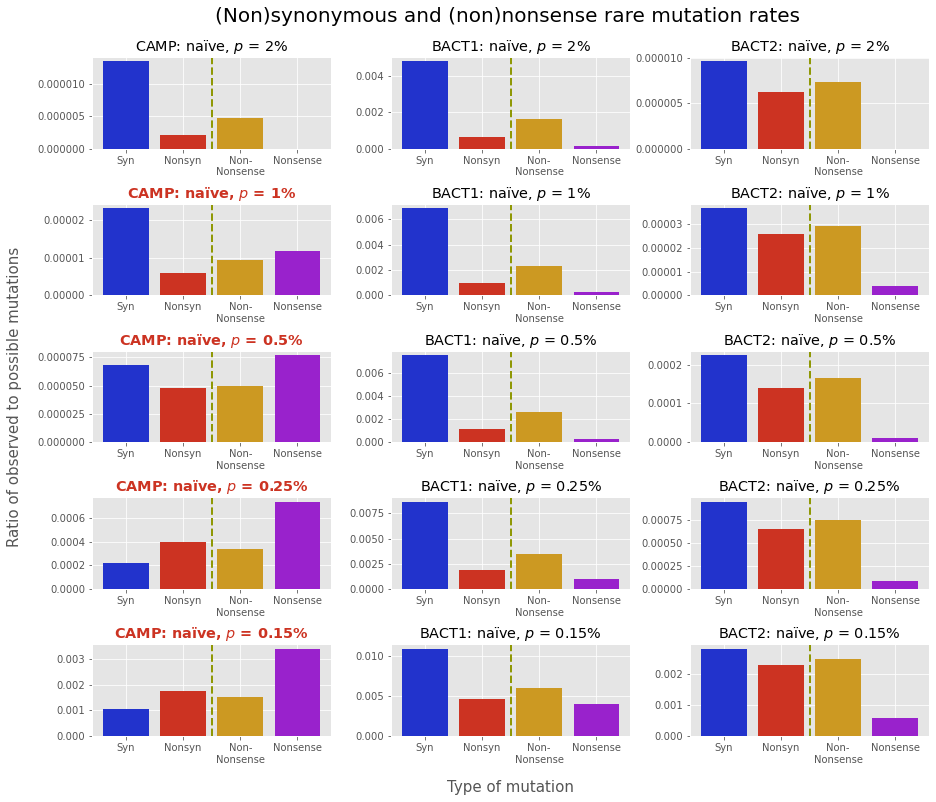

In [25]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.6, "wspace": 0.25})

if len(percentages) % 2 == 0:
    # Really, the precise middle is between two rows, right? anyway as of writing we use 7 percentages
    # so this never happens
    middle_row = len(percentages) / 2
else:
    middle_row = percentages.index(median(percentages))

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rs = p2seq2obs_si[p][seq] / seq2poss_si[seq]
        rn = p2seq2obs_ni[p][seq] / seq2poss_ni[seq]
        rnns = p2seq2obs_nnsi[p][seq] / seq2poss_nnsi[seq]
        rns = p2seq2obs_nsi[p][seq] / seq2poss_nsi[seq]
        axes[pi, si].bar(
            ["Syn", "Nonsyn", "Non-\nNonsense", "Nonsense"],
            [rs, rn, rnns, rns],
            color=["#2233cc", "#cc3322", "#cc9922", "#9922cc"]
        )
        axes[pi, si].ticklabel_format(axis="y", style="plain")
        
        # Visually indicate that these are two separate comparisons (syn vs nonsyn and nns vs ns).
        # The x = 1.5 is because x = 0 seems to correspond to the center of the leftmost bar (i.e.
        # syn), so we can slap a bar right in the middle of the middle two bars by using
        # x = (1 + 2)/2 = 1.5. nice!
        #
        # btw, regarding the color choice: it actually works pretty well for this plot. It has all
        # the qualities I look for in a line color for a plot like this: it's neutral, it's dark green,
        # it's unobtrusive, it's named "baby poop green", and so on. 
        axes[pi, si].axvline(x=1.5, linestyle="--", color="xkcd:baby poop green", linewidth=2)
        
        titlecolor="#000000"
        titleweight="normal"
        if rs <= rn or rnns <= rns:
            # This color choice matches the CP1/2/3 plots. nice!
            titlecolor = "#cc3322"
            titleweight = "semibold"
            
        axes[pi, si].set_title(
            f"{seq2name[seq]}: na\u00efve, $p$ = {p}%",
            color=titlecolor,
            fontweight=titleweight
        )
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)

axes[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig.suptitle("(Non)synonymous and (non)nonsense rare mutation rates", y=0.935, x=0.51, fontsize=20)
fig.set_size_inches(15, 12.5)
fig.savefig("figs/nonsyn-nonsense-barplots.png", bbox_inches="tight")